In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from matplotlib.patches import Patch
import string as st
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


C:\Users\hazem\AppData\Local\Temp\ipykernel_149092\691100156.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',60)

# https://www.kaggle.com/datasets/divyansh22/online-gaming-anxiety-data
csv_path = "data/GamingStudy_data.csv"
data = pd.read_csv(csv_path, encoding='latin1')



In [3]:
display(data.head())
print(f"This dataset has {data.shape[0]} data samples and {data.shape[1]} features.")
duplicate_samples = data.duplicated().sum()
print(f"\nNumber of duplicate samples: {duplicate_samples}")

,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,SWL1,SWL2,SWL3,SWL4,SWL5,Game,Platform,Hours,earnings,whyplay,League,highestleague,streams,SPIN1,SPIN2,SPIN3,SPIN4,SPIN5,SPIN6,SPIN7,SPIN8,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,Narcissism,Gender,Age,Work,Degree,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.00437,0,0,0,0,1,0,0,Not difficult at all,3,5,5,5,5,Skyrim,"Console (PS, Xbox, ...)",15.0,I play for fun,having fun,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Male,25,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.00680,1,2,2,2,0,1,0,Somewhat difficult,3,5,2,5,1,Other,PC,8.0,I play for fun,having fun,NaN,NaN,2.0,2.0,1.0,1.0,3.0,2.0,3.0,1.0,3.0,4.0,0.0,3.0,0.0,1.0,3.0,3.0,1.0,2.0,1.0,Male,41,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.03860,0,2,2,0,0,3,1,Not difficult at all,2,6,5,2,2,Other,PC,0.0,I play for fun,having fun,NaN,NaN,0.0,1.0,0.0,1.0,2.0,3.0,4.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,4.0,4.0,2.0,4.0,Female,32,Employed,Bachelor (or equivalent),Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.06804,0,0,0,0,0,0,0,Not difficult at all,2,5,5,3,2,Other,PC,20.0,I play for fun,improving,NaN,NaN,5.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,2.0,Male,28,Employed,Bachelor (or equivalent),USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.08948,2,1,2,2,2,3,2,Very difficult,2,2,4,5,1,Other,"Console (PS, Xbox, ...)",20.0,I play for fun,having fun,NaN,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,Male,19,Employed,High school diploma (or equivalent),USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


This dataset has 13464 data samples and 55 features.

Number of duplicate samples: 0


In [4]:
column_types = {
    "S. No.": "Nominal Categorical",
    "Timestamp": "Continuous Numerical",
    **{f"GAD{i}": "Ordinal Categorical" for i in range(1, 8)},
    **{f"SWL{i}": "Ordinal Categorical" for i in range(1, 6)},
    **{f"SPIN{i}": "Ordinal Categorical" for i in range(1, 18)},
    "GADE": "Ordinal Categorical",
    "Game": "Nominal Categorical",
    "Platform": "Nominal Categorical",
    "Hours": "Continuous Numerical",
    "Earnings": "Text",
    "whyplay": "Text",
    "Narcissism": "Ordinal Categorical",
    "Gender": "Nominal Categorical",
    "Age": "Discrete Numerical",
    "Work": "Nominal Categorical",
    "Degree": "Nominal Categorical",
    "Birthplace": "Nominal Categorical",
    "Residence": "Nominal Categorical",
    "Birthplace_ISO3": "Nominal Categorical",
    "Residence_ISO3": "Nominal Categorical",
    "Reference": "Nominal Categorical",
    "Playstyle": "Text",
    "accept": "Nominal Categorical",
    "GAD_T": "Discrete Numerical",
    "SWL_T": "Discrete Numerical",
    "SPIN_T": "Discrete Numerical",
    "streams": "Discrete Numerical",
    "League": "Text",
    "earnings": "Text",
}

# Assign variable type to all columns
data_types = pd.Series({col: column_types.get(col, "Unknown") for col in data.columns}, name="Variable Type")

# Calculate missing values and their percentage
total_rows = len(data)
missing_summary = pd.DataFrame({
    'Missing Values': data.isna().sum(),
    'Percentage': (data.isna().sum() / total_rows) * 100,
    'Variable Type': data_types
}).sort_values(by='Missing Values', ascending=False)

# Display the summary
display(missing_summary)
display(data.info())

,Missing Values,Percentage,Variable Type
highestleague,13464,100.000000,Unknown
League,1852,13.755199,Text
Degree,1577,11.712715,Nominal Categorical
SPIN_T,650,4.827689,Discrete Numerical
GADE,649,4.820261,Ordinal Categorical
accept,414,3.074866,Nominal Categorical
SPIN13,187,1.388889,Ordinal Categorical
SPIN11,187,1.388889,Ordinal Categorical
SPIN17,175,1.299762,Ordinal Categorical
SPIN12,168,1.247772,Ordinal Categorical


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13464 entries, 0 to 13463
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S. No.           13464 non-null  int64  
 1   Timestamp        13464 non-null  float64
 2   GAD1             13464 non-null  int64  
 3   GAD2             13464 non-null  int64  
 4   GAD3             13464 non-null  int64  
 5   GAD4             13464 non-null  int64  
 6   GAD5             13464 non-null  int64  
 7   GAD6             13464 non-null  int64  
 8   GAD7             13464 non-null  int64  
 9   GADE             12815 non-null  object 
 10  SWL1             13464 non-null  int64  
 11  SWL2             13464 non-null  int64  
 12  SWL3             13464 non-null  int64  
 13  SWL4             13464 non-null  int64  
 14  SWL5             13464 non-null  int64  
 15  Game             13464 non-null  object 
 16  Platform         13464 non-null  object 
 17  Hours       

None

Each of the variables above has been marked as categorical, numerical, or text data. One thing to note from the table above is that most of the variables do not have any missing values in any of the rows. The highest league variable has absolutely no entries, which means that it will not be considered in any of the future calculations or models for this dataset.

C:\Users\hazem\AppData\Local\Temp\ipykernel_149092\2513002026.py:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout
C:\Users\hazem\AppData\Local\Temp\ipykernel_149092\2513002026.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))  # Set the size for each plot


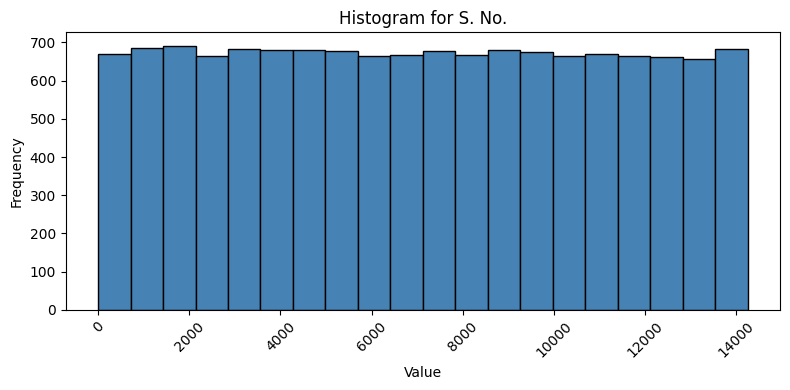

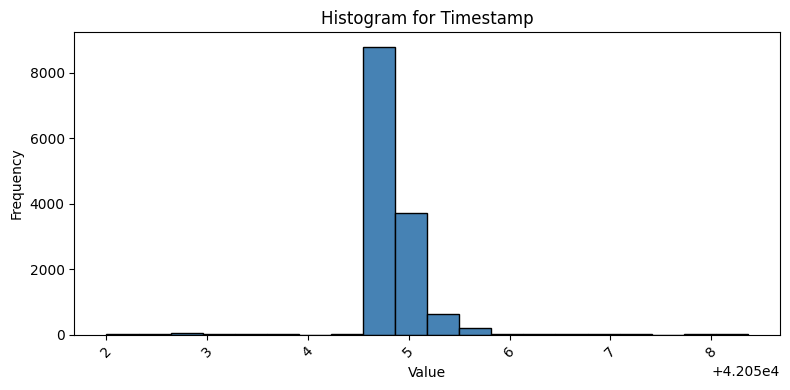

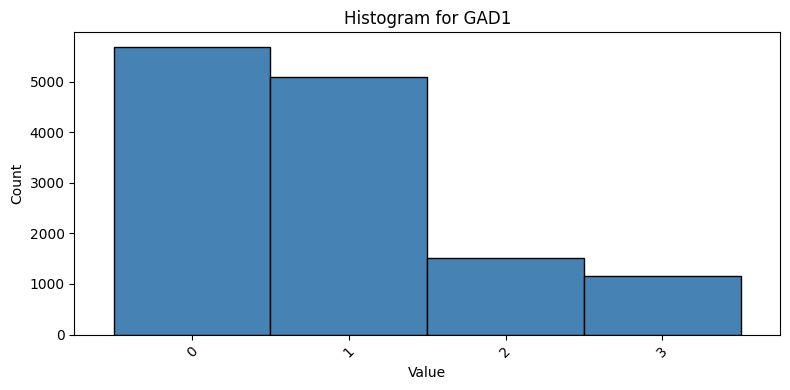

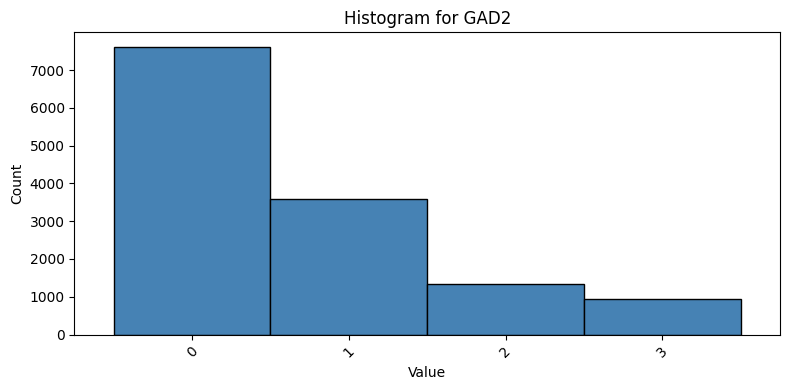

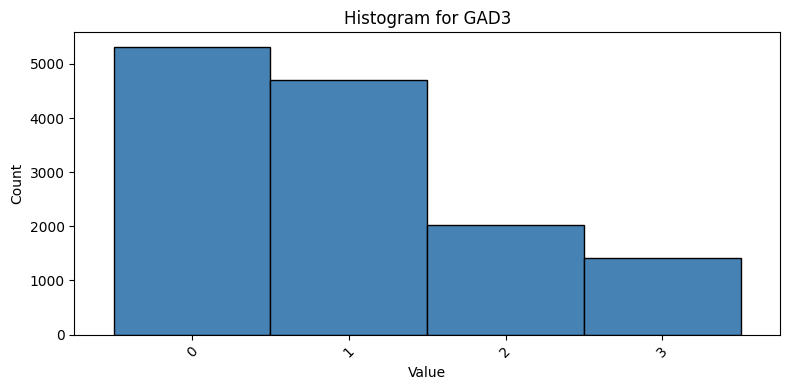

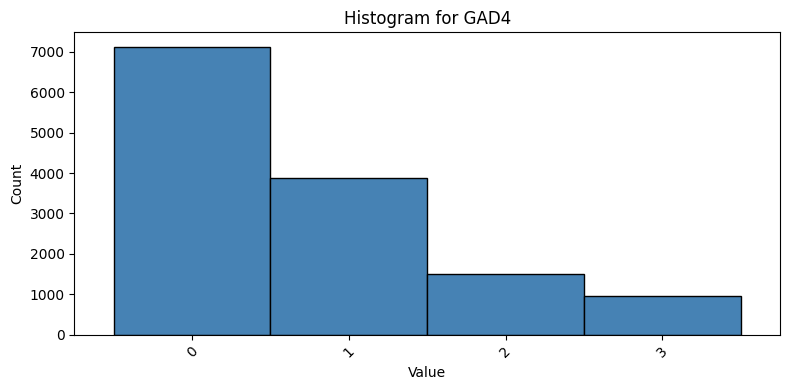

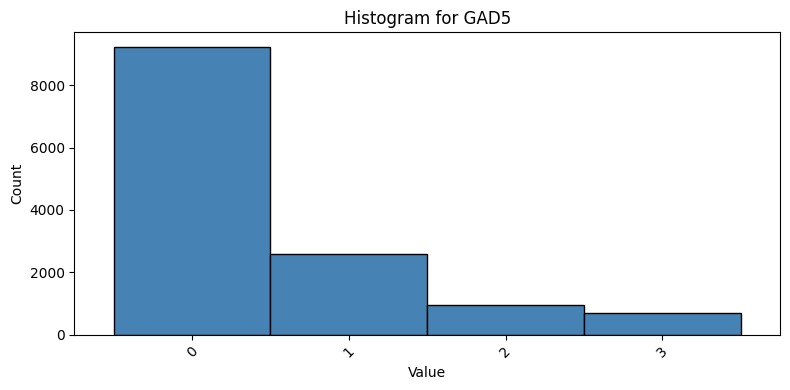

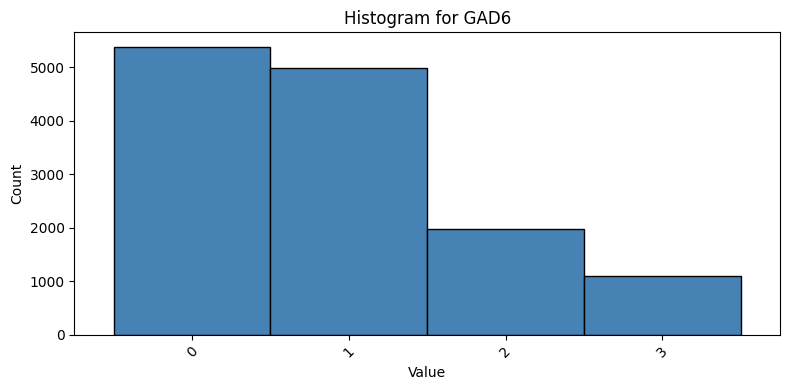

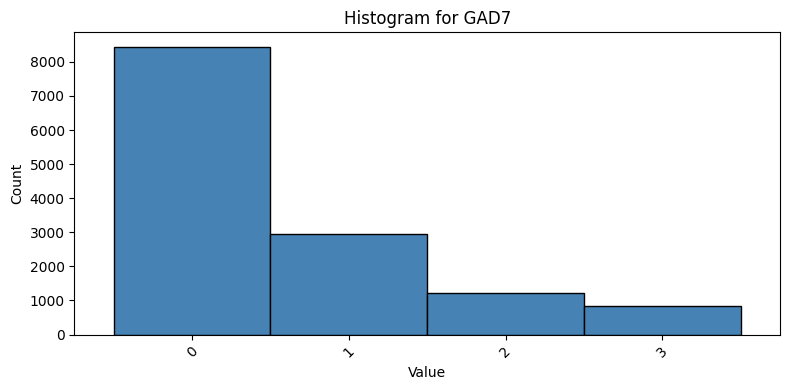

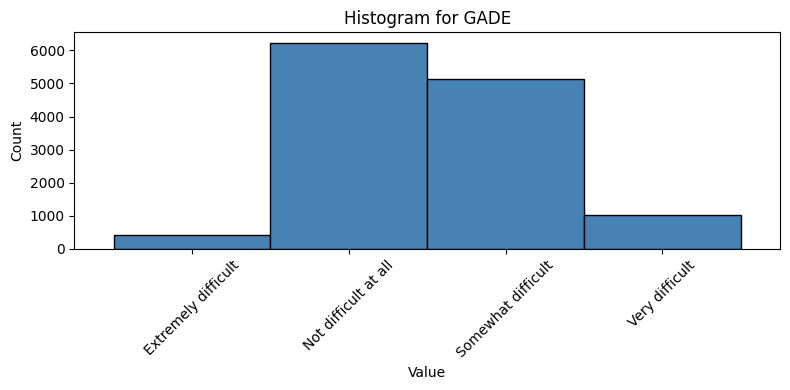

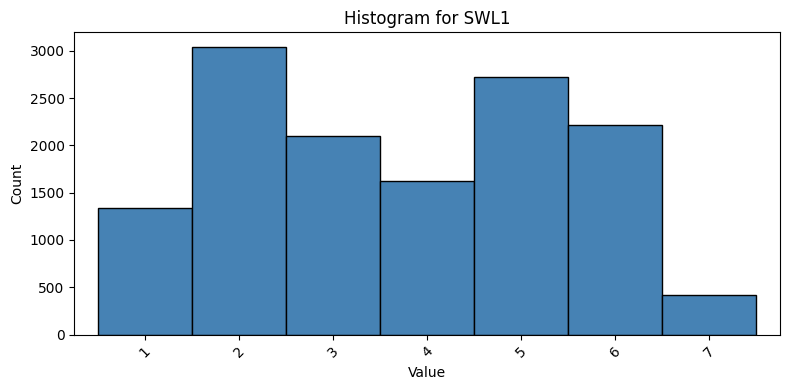

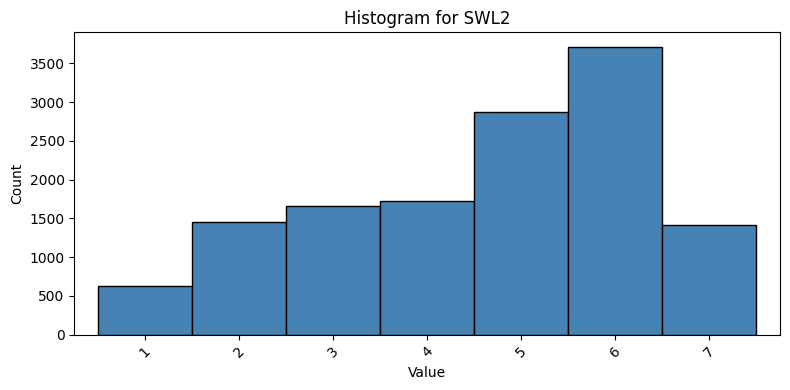

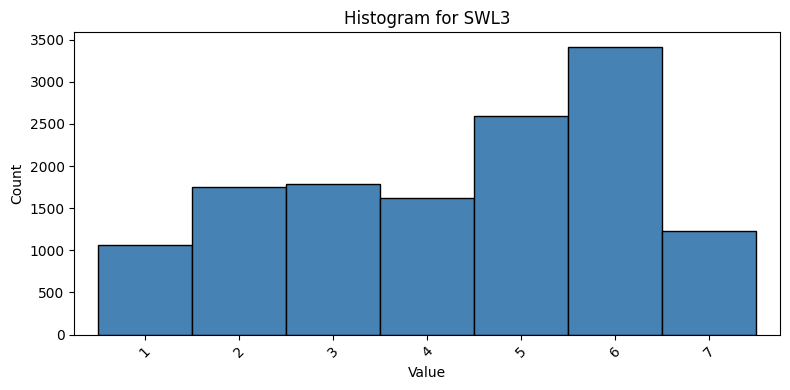

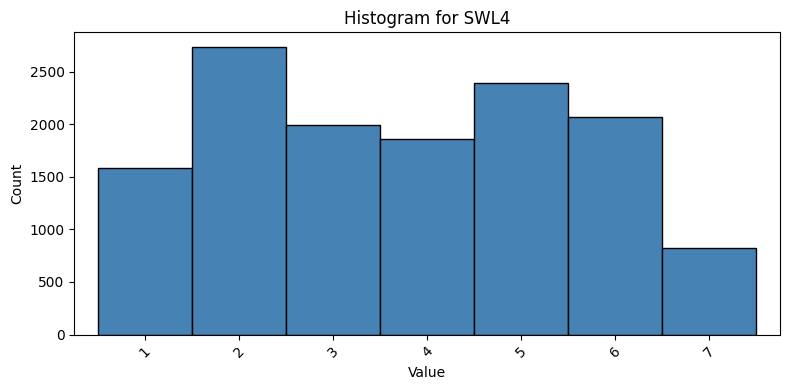

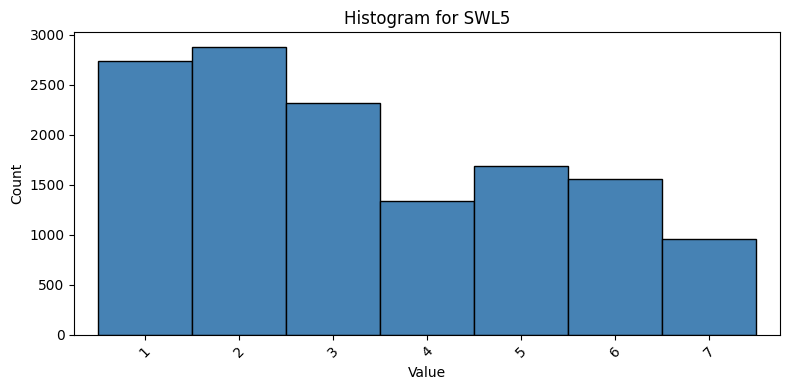

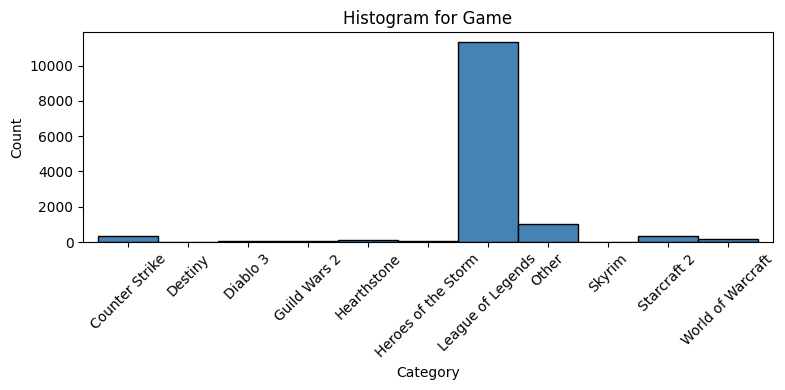

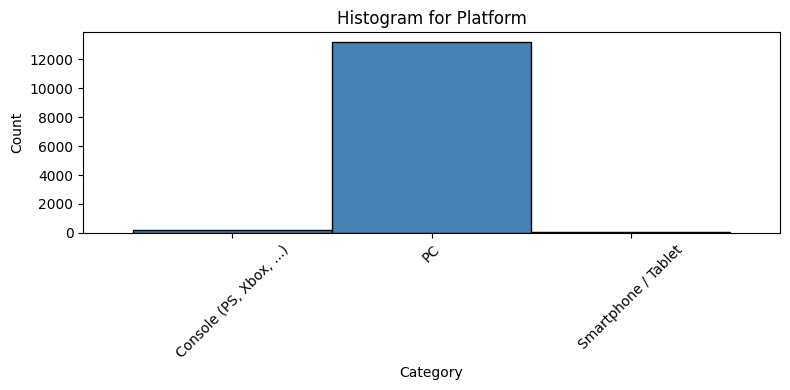

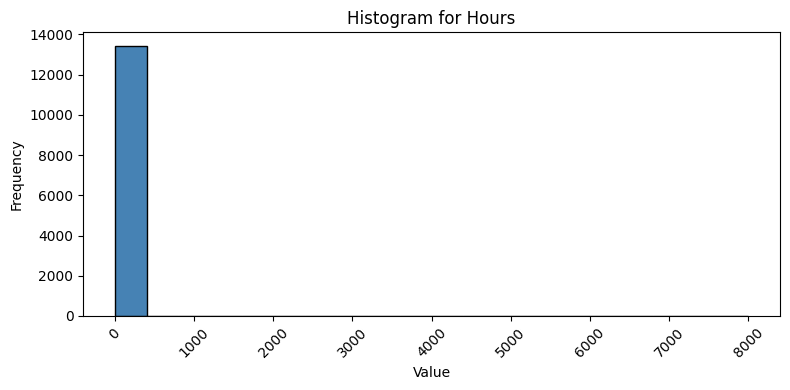

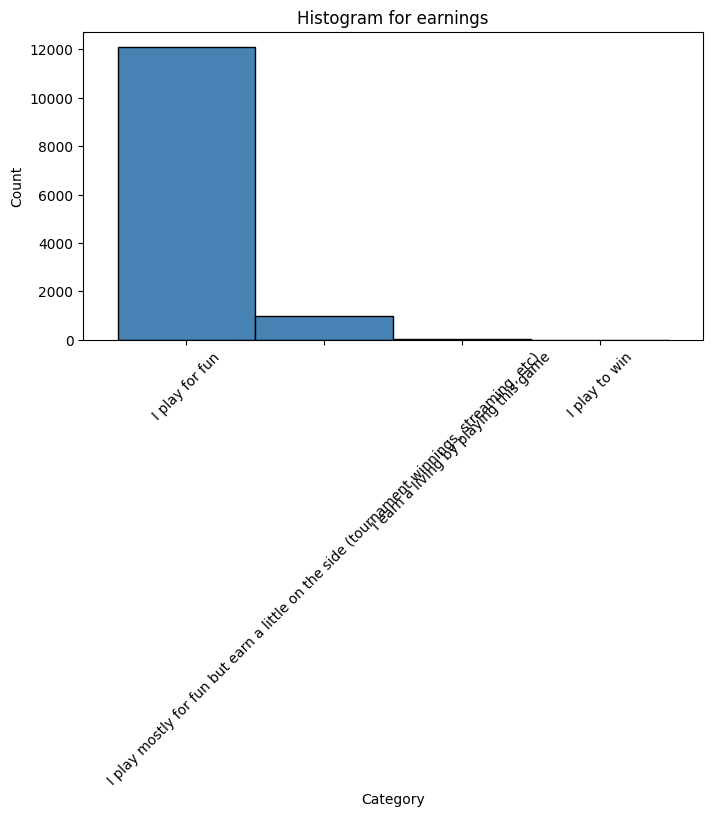

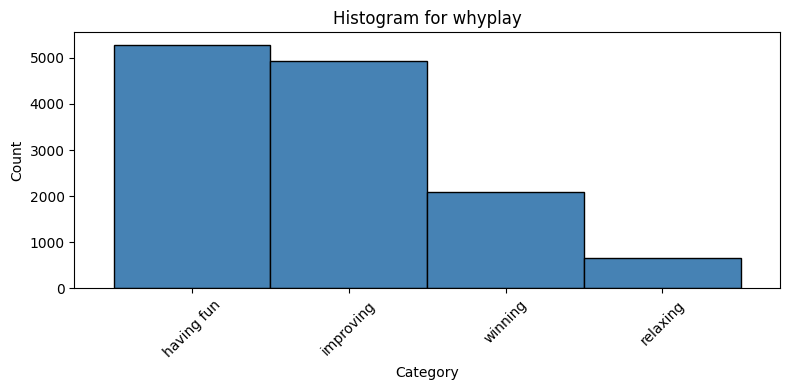

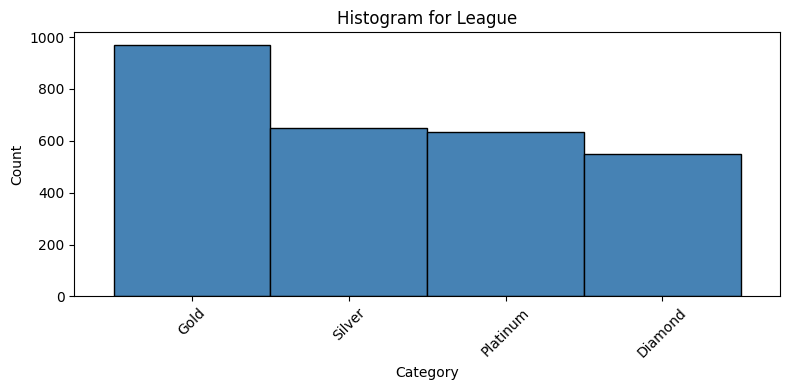

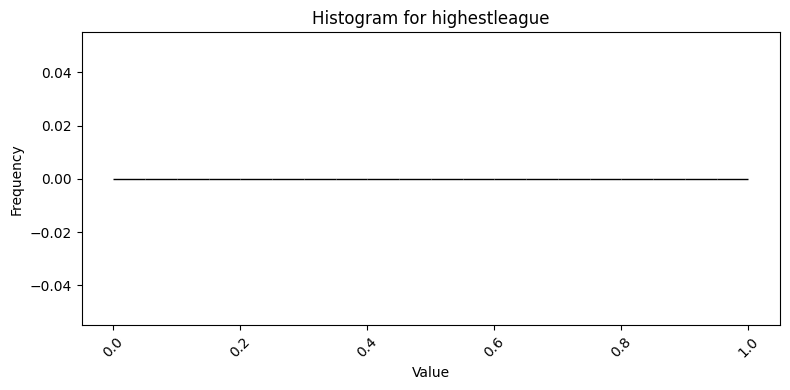

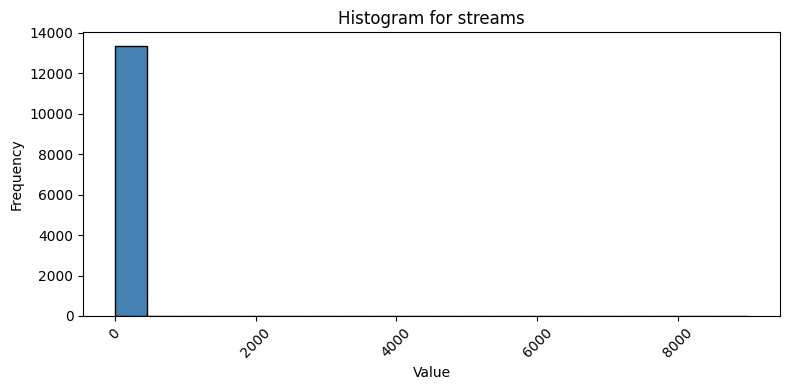

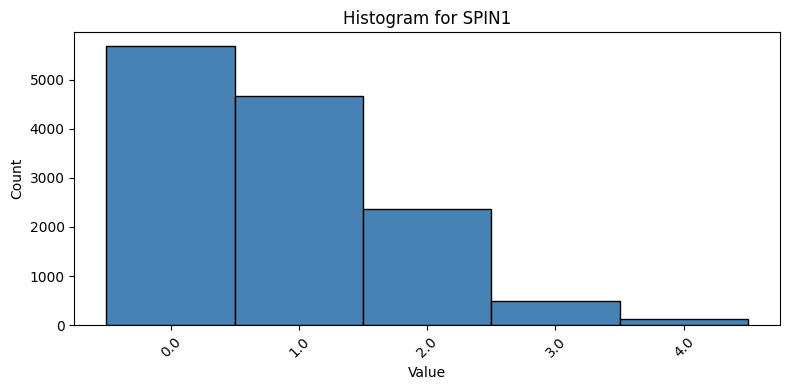

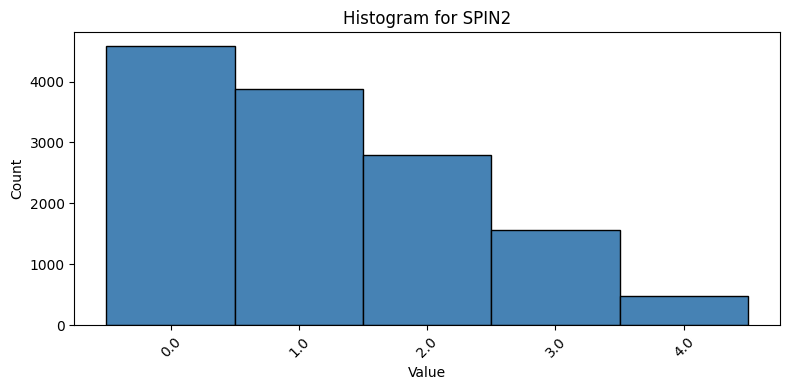

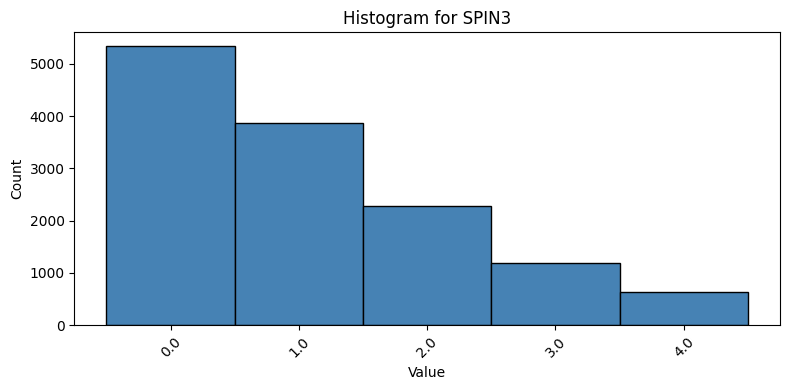

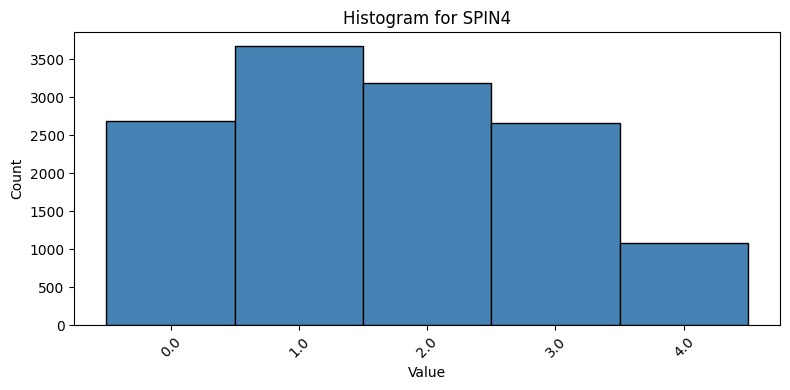

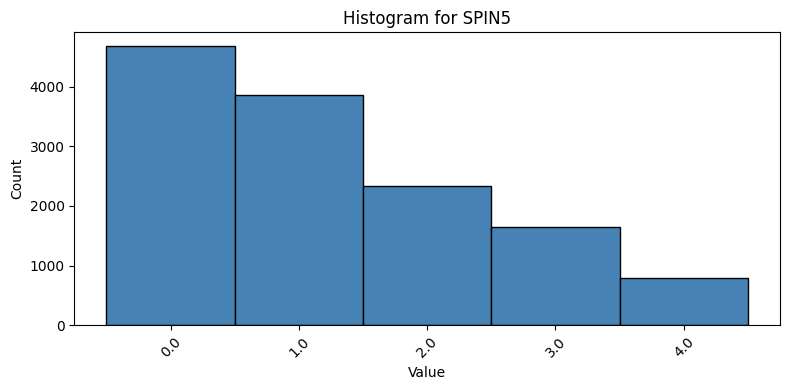

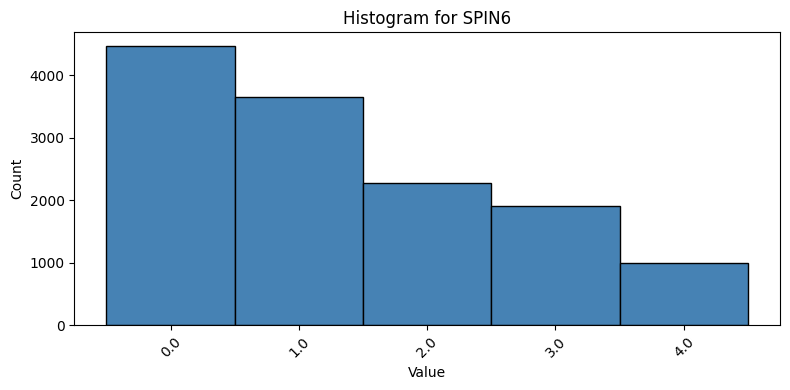

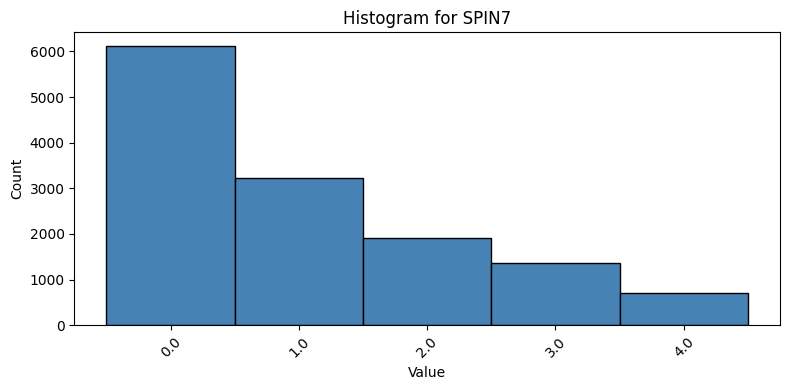

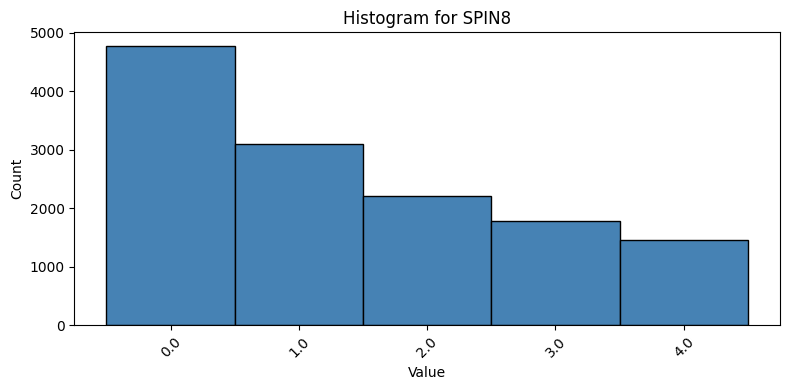

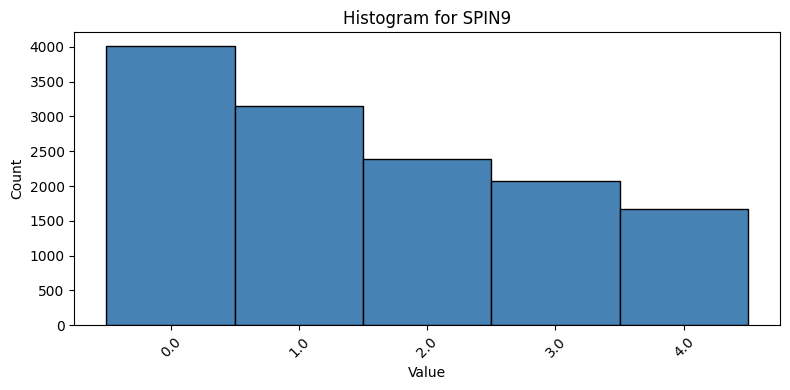

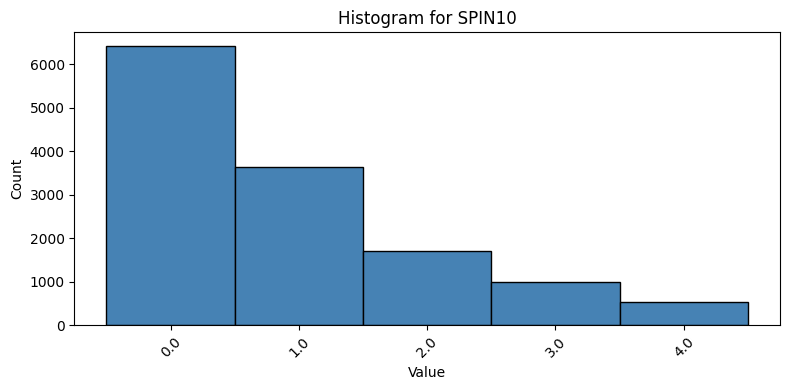

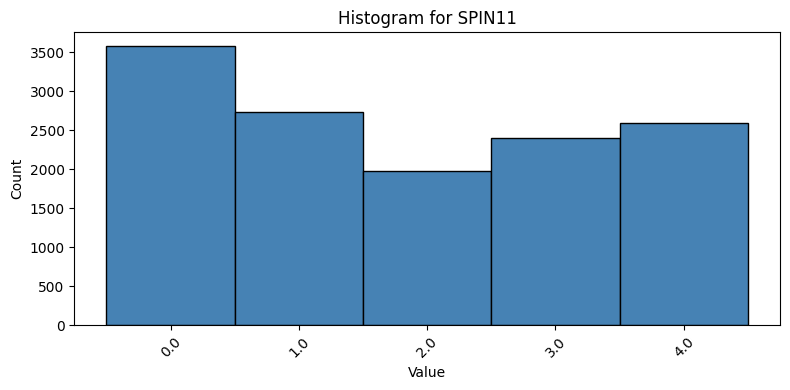

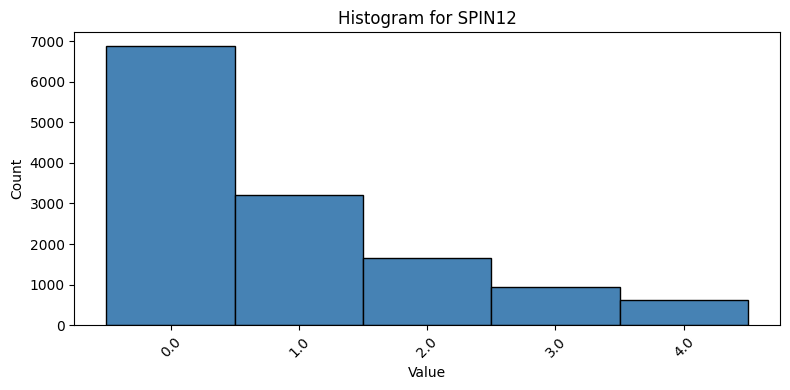

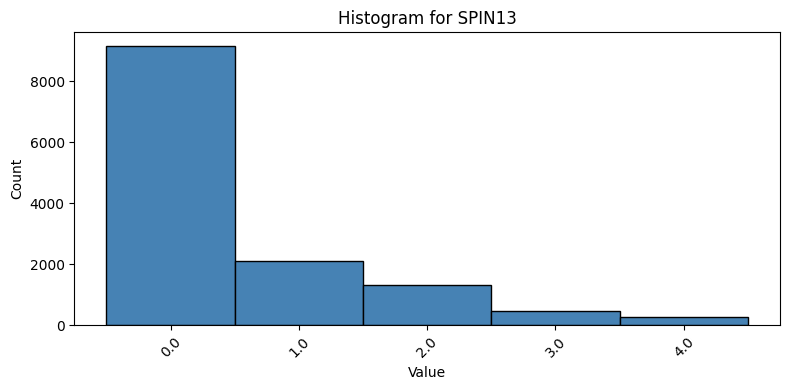

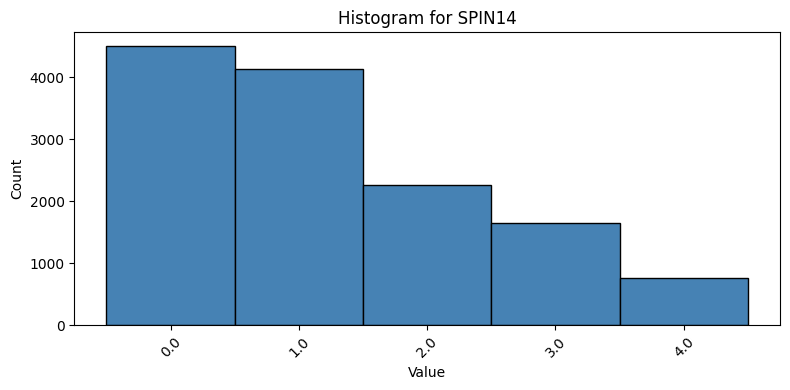

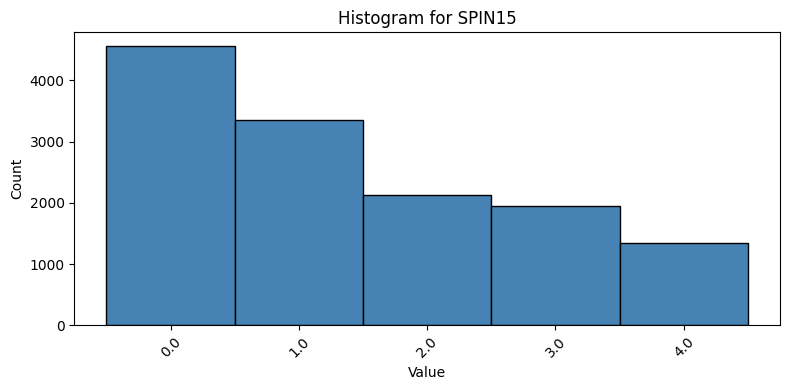

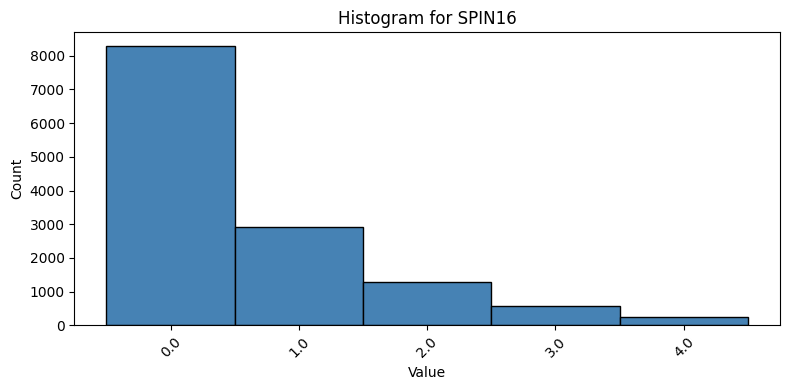

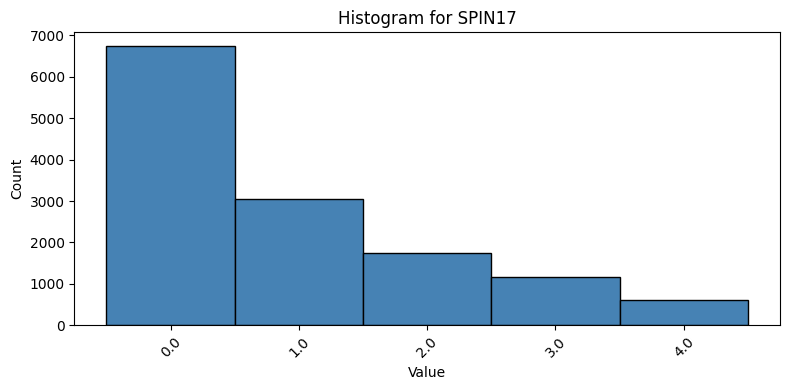

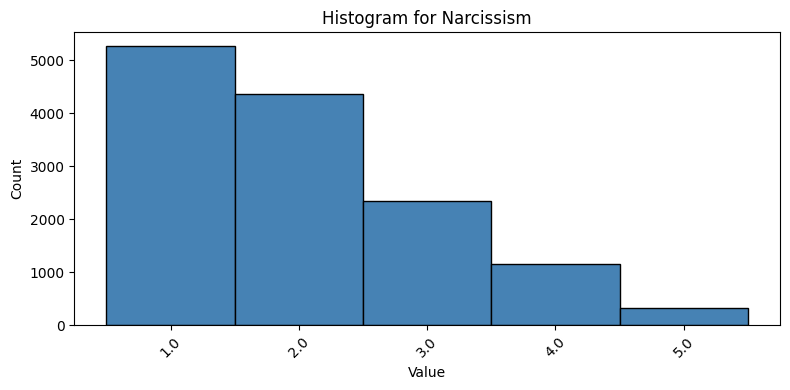

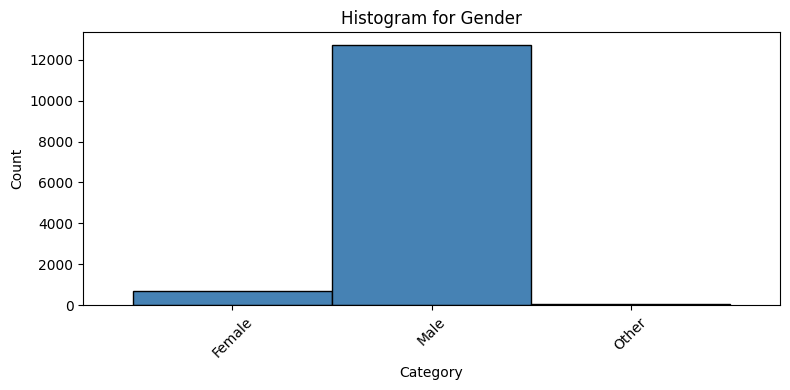

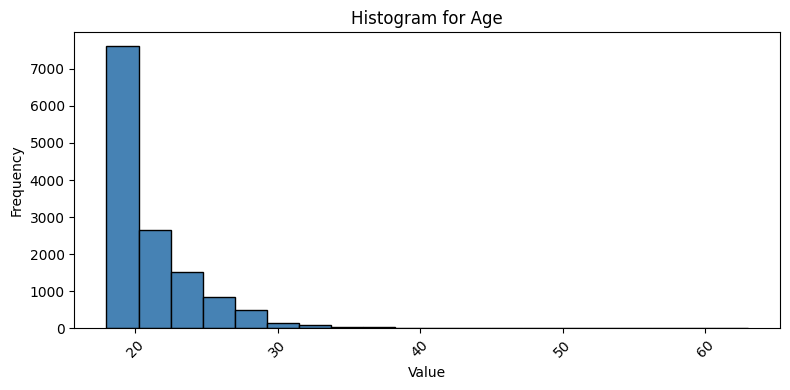

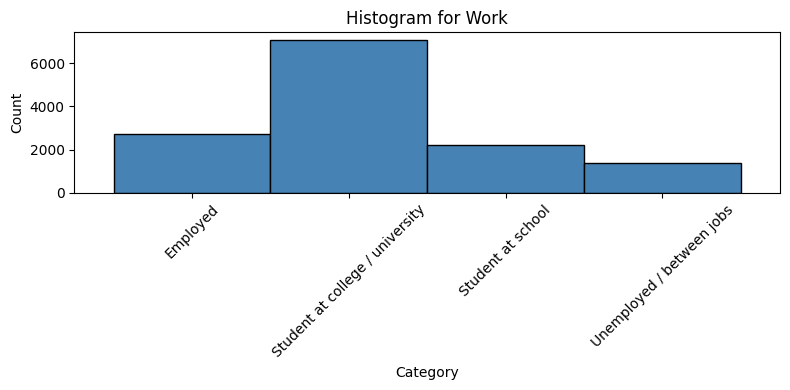

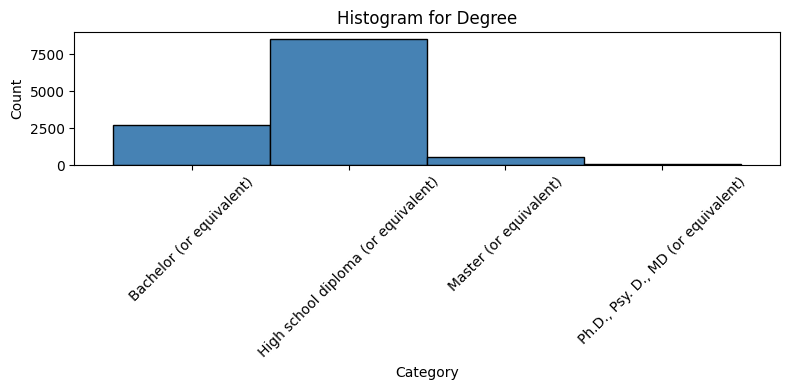

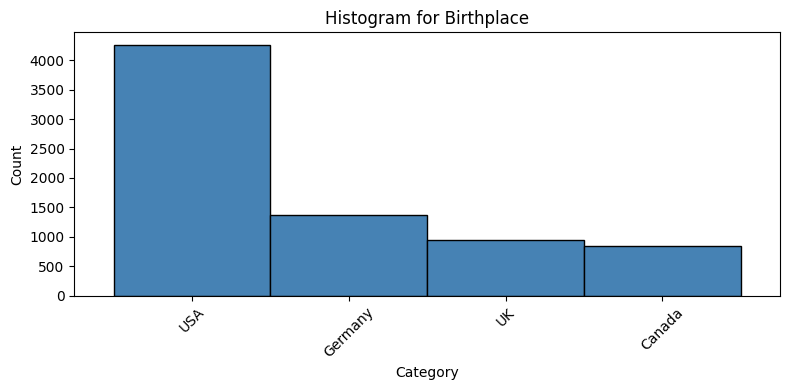

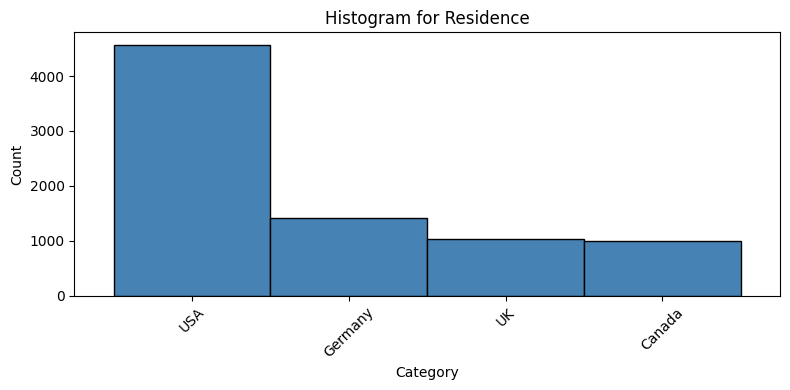

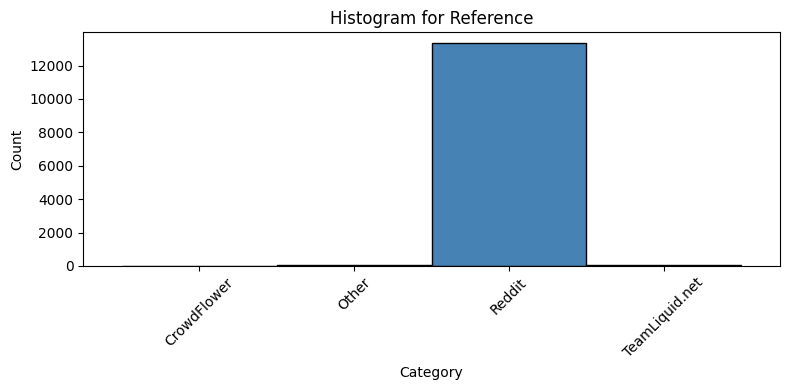

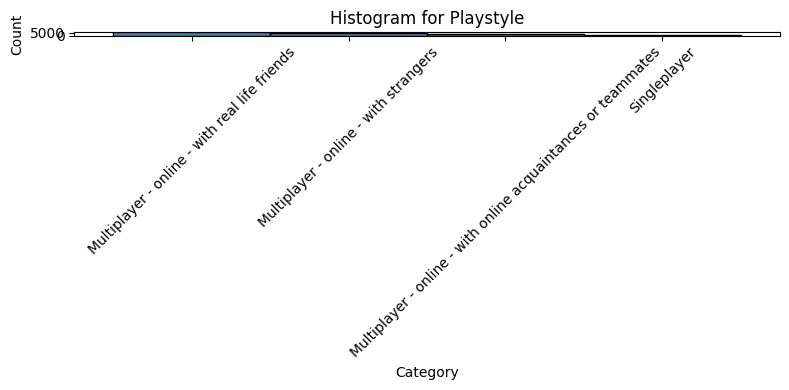

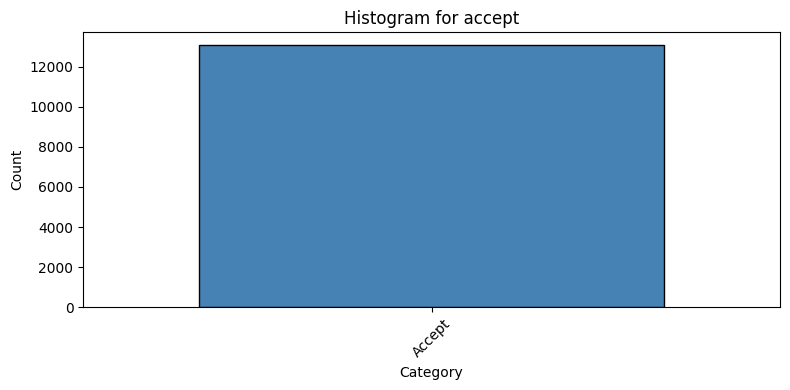

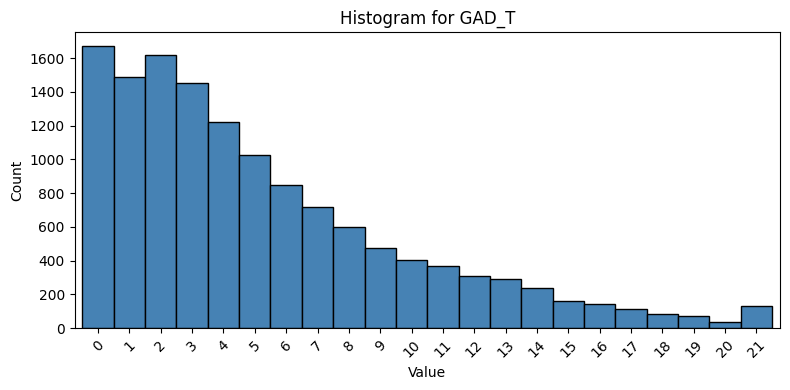

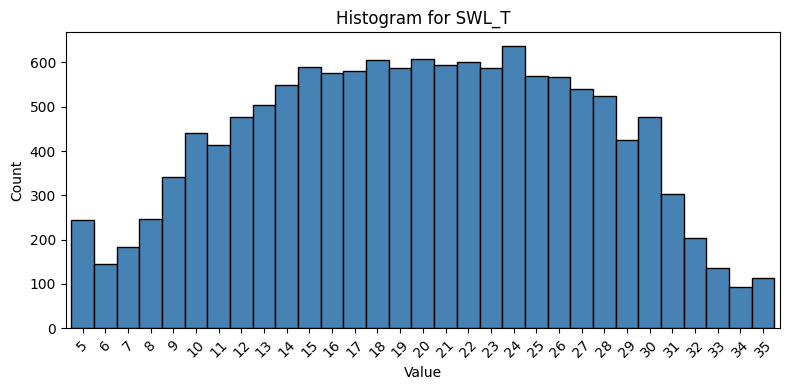

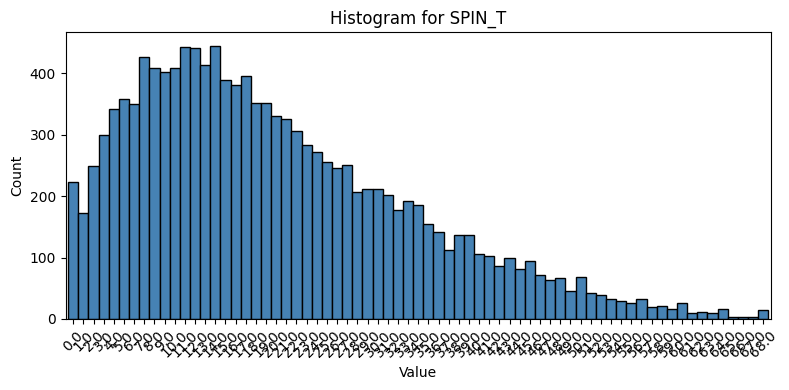

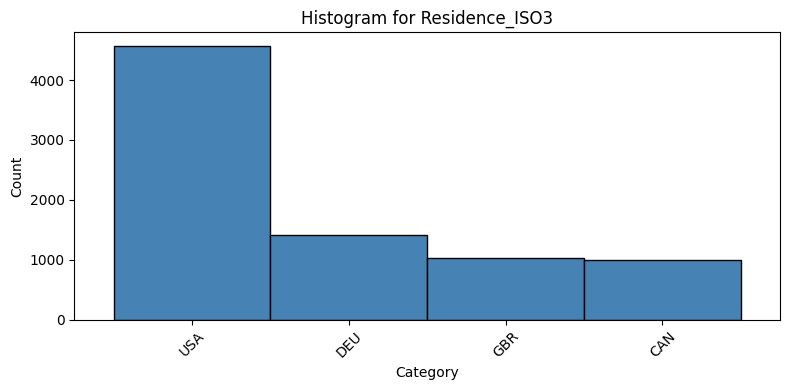

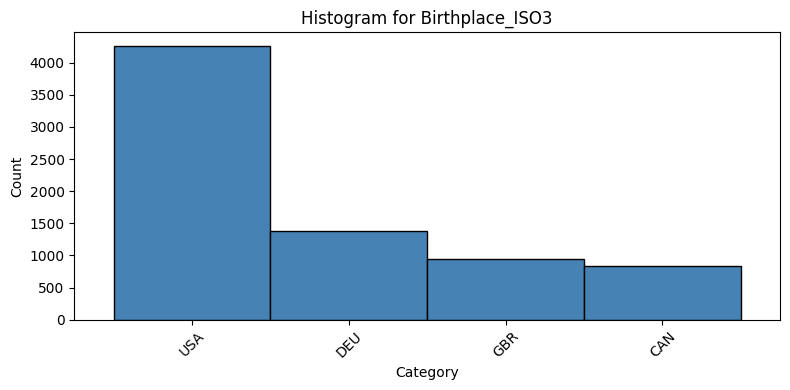

In [5]:
for column in data.columns:
    unique_values = data[column].nunique()  # Count unique values

    plt.figure(figsize=(8, 4))  # Set the size for each plot

    # Check if the column name contains 'GAD', 'SPIN', 'SWL', or 'Narcissism'
    if any(keyword in column for keyword in ['GAD', 'SPIN', 'SWL', 'Narcissism']):
        # Treat as discrete whole values
        if unique_values > 80:  # If more than 80 unique values, plot top 40
            top_40 = data[column].value_counts().head(4)
            top_40.plot(kind='bar', color='steelblue', edgecolor='black', width=1.0)
        else:
            data[column].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black', width=1.0)
        
        plt.xlabel('Value')
        plt.ylabel('Count')
        
    elif data[column].dtype in ['int64', 'float64']:  # Numerical features
        # Use plt.hist for numerical data
        plt.hist(data[column].dropna(), bins=20, color='steelblue', edgecolor='black')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    else:  # Other categorical features
        if unique_values > 80:  # If more than 80 unique values, plot top 40
            top_40 = data[column].value_counts().head(4)
            top_40.plot(kind='bar', color='steelblue', edgecolor='black', width=1.0)
        else:
            data[column].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black', width=1.0)

        plt.xlabel('Category')
        plt.ylabel('Count')

    plt.title(f'Histogram for {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout
    # plt.show()  # Display the plot


# Dataset Description and Analysis

The dataset contains several features, each with its own significance. Below is a detailed description of each feature:

## Features

### **S. No.**
- **Description**: Subject number in the dataset.
- **Type**: Nominal categorical variable (value has no inherent meaning).

### **Timestamp**
- **Description**: Timestamp when the online gaming anxiety data was collected.
- **Type**: Continuous numerical variable.

### **Survey Questions: GAD1 to GAD7**
- **Description**: Questions related to generalized anxiety on a scale of 1 to 3:
  - 1: Statement never occurred within the last 2 weeks.
  - 3: Statement occurred every day within the last 2 weeks.
- **Type**: Ordinal categorical variable.
- **Questions**:
  1. Feeling nervous, anxious, or on edge?
  2. Not being able to stop or control worrying?
  3. Worrying too much about different things?
  4. Having trouble relaxing?
  5. Being so restless that it’s hard to sit still?
  6. Becoming easily annoyed or irritable?
  7. Feeling afraid as if something awful might happen?
- **Observation**: Responses are right-skewed (lower end of the scale).

### **Survey Questions: SWL1 to SWL5**
- **Description**: Questions related to satisfaction with life on a scale of 1 to 5:
  - 1: Strongly disagree.
  - 5: Strongly agree.
- **Type**: Ordinal categorical variable.
- **Statements**:
  1. In most ways, my life is close to my ideal.
  2. I am bothered by blushing in front of people.
  3. Parties and social events scare me.
  4. I avoid talking to people I don't know.
  5. Being criticized scares me a lot.
- **Observation**: Data has a balanced distribution.

### **Survey Questions: SPIN1 to SPIN17**
- **Description**: Questions related to the social phobia inventory scale on a scale of 0 to 4:
  - 0: Statement does not apply at all.
  - 4: Statement applies extremely.
- **Type**: Ordinal categorical variable.
- **Observation**: Responses are right-skewed.

### **GADE**
- **Description**: Effect of gaming on work.
- **Type**: Ordinal categorical variable.
- **Observation**: Most responses are "Not difficult at all" or "Somewhat difficult."

### **Game**
- **Description**: Name of the game the participant plays.
- **Type**: Nominal categorical variable.
- **Observation**: Majority of participants play "League of Legends."

### **Platform**
- **Description**: Mode of game playing (e.g., mobile, PC, console).
- **Type**: Nominal categorical variable.
- **Observation**: Most participants are PC gamers.

### **Hours**
- **Description**: Number of hours per week spent gaming.
- **Type**: Continuous numerical variable.

### **Earnings**
- **Description**: Indicates if the participant earns money through gaming (text data).
- **Observation**: Most participants play for fun.

### **Whyplay**
- **Description**: Reason for playing games (text data).
- **Observation**: Common reasons include fun, improvement, winning, or relaxation.

### **League**
- **Description**: Participant's league in the game.
- **Type**: Ordinal categorical variable.
- **Observation**: Most participants are in Gold, Silver, Platinum, or Diamond leagues.

### **Narcissism**
- **Description**: Participant's interest in the game (scale of 1 to 5).
- **Type**: Ordinal categorical variable.
- **Observation**: Right-skewed data.

### **Gender**
- **Description**: Participant's gender.
- **Type**: Nominal categorical variable.
- **Observation**: Most participants identify as male.

### **Age**
- **Description**: Participant's age in years.
- **Type**: Discrete numerical variable.
- **Observation**: Most participants are around 20 years old.

### **Work**
- **Description**: Participant's work status.
- **Type**: Nominal categorical variable.
- **Observation**: Most participants are college students.

### **Degree**
- **Description**: Highest academic degree attained.
- **Type**: Nominal categorical variable.
- **Observation**: Majority have a high school diploma.

### **Birthplace**
- **Description**: Participant's birthplace country.
- **Type**: Nominal categorical variable.
- **Observation**: Most participants are born in the USA.

### **Residence**
- **Description**: Current country of residence.
- **Type**: Nominal categorical variable.
- **Observation**: Most participants reside in the USA.

### **Reference**
- **Description**: Source of the questionnaire.
- **Type**: Nominal categorical variable.
- **Observation**: Most participants were referred via Reddit.

### **Playstyle**
- **Description**: Participant's playstyle (e.g., multiplayer, singleplayer).
- **Type**: Text data.

### **Accept**
- **Description**: Indicates if the participant accepted the questionnaire terms.
- **Type**: Nominal categorical variable.

### **GAD_T**
- **Description**: Sum of the GAD scores.
- **Type**: Discrete numerical variable.

### **SWL_T**
- **Description**: Sum of the SWL scores.
- **Type**: Discrete numerical variable.

### **SPIN_T**
- **Description**: Sum of the SPIN scores.
- **Type**: Discrete numerical variable.

### **Streams**
- **Description**: Number of online game streams.
- **Type**: Discrete numerical variable.
- **Observation**: Most participants have close to 0 streams.


# PREPROCESSING

In [6]:

data = data.drop(data[data['accept'].isnull()].index, axis=0)

data['Work'] = data['Work'].fillna(data['Work'].mode()[0])
data['GADE'] = data['GADE'].fillna(data['GADE'].value_counts().index[1])
data['streams'] = data['streams'].fillna(int(data['streams'].mean()))
data['Hours'] = data['Hours'].fillna(int(data['Hours'].mean()))

data['League'] = data['League'].str.lower().str.strip()
data['League'] = data['League'].str.extract(r'^([a-z]+)')
data.loc[data['whyplay'] == 'having fun', 'League'] = data.loc[data['whyplay'] == 'having fun', 'League'].fillna('unranked')
data['League'] = data['League'].fillna('gold')

counts = data['League'].value_counts()
valid_leagues = ~data['League'].isin(counts[counts < 3].index)
data.loc[~valid_leagues, 'League'] = np.nan

data['League'] = data['League'].replace(
    ['i', 'currently', 'high', 'season', 'lol', 'cs', 'last', 'csgo', 'starcraft', 'geater', 'in', 'rank', 'still'],
    np.nan
)
data['League'] = data['League'].fillna('unspecified')

cols = ['SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8', 'SPIN9', 
        'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15', 'SPIN16', 'SPIN17', 'SPIN_T']
for col in cols:
    data[col] = data[col].fillna(data[col].mode()[0])


for col in ['Playstyle', 'earnings', 'whyplay']:
    data[col] = data[col].apply(lambda x: ' '.join(word.strip(st.punctuation) for word in x.split()))
    data[col] = data[col].str.lower().str.strip()

data['earnings'] = data['earnings'].replace(data['earnings'].value_counts().index[3:], 'Other')
data['whyplay'] = data['whyplay'].replace(data['whyplay'].value_counts().index[5:], 'Other')
data['Playstyle'] = data['Playstyle'].replace(data['Playstyle'].value_counts().index[5:], 'Other')

data['Playstyle'] = data['Playstyle'].replace('Other', np.nan)
data['whyplay'] = data['whyplay'].replace('Other', np.nan)
data['earnings'] = data['earnings'].replace('Other', np.nan)
data['Platform'] = data['Platform'].replace('Console (PS, Xbox, ...)', 'Console')



The code above aims to clean up the dataset from any null values or columns that could perhaps cause bias in the study. The columns that were dropped include highestleague, S. No., Timestamp, variables related to birthplace and current place of residence, and those who did not accept to participate in the study. Dropping these columns allows for the removal of certain local biases in the data as well as respects the consent of the participants in the study.

Next, the code handles missing data in several columns. For the 'Work' column, missing values are replaced with the most frequent value (mode), which ensures that the dataset remains complete without introducing arbitrary or biased assumptions. Similarly, missing values in the 'GADE' column are filled with the second most common value to reflect the most likely category. The 'streams' and 'Hours' columns, which are numerical, have missing values replaced with their respective column mean, converted to integers. This ensures numerical consistency and prevents missing data from skewing any analysis that requires these variables.

Additionally, the code cleans up the 'League' column, which holds information about a player's ranking, by standardizing the text entries. It converts all values to lowercase and strips any surrounding whitespace to ensure uniformity. For missing values in the 'League' column, the code fills in defaults such as 'gold' or 'unranked', based on specific conditions. The 'League' column is also further cleaned by eliminating values that appear less than three times, ensuring that only valid and relevant league categories remain in the data. The same approach is applied to the 'Playstyle', 'earnings', 'whyplay', and 'Platform' columns to replace rare values with a category labeled as 'Other', and to further clean up any outliers or inconsistent entries. 

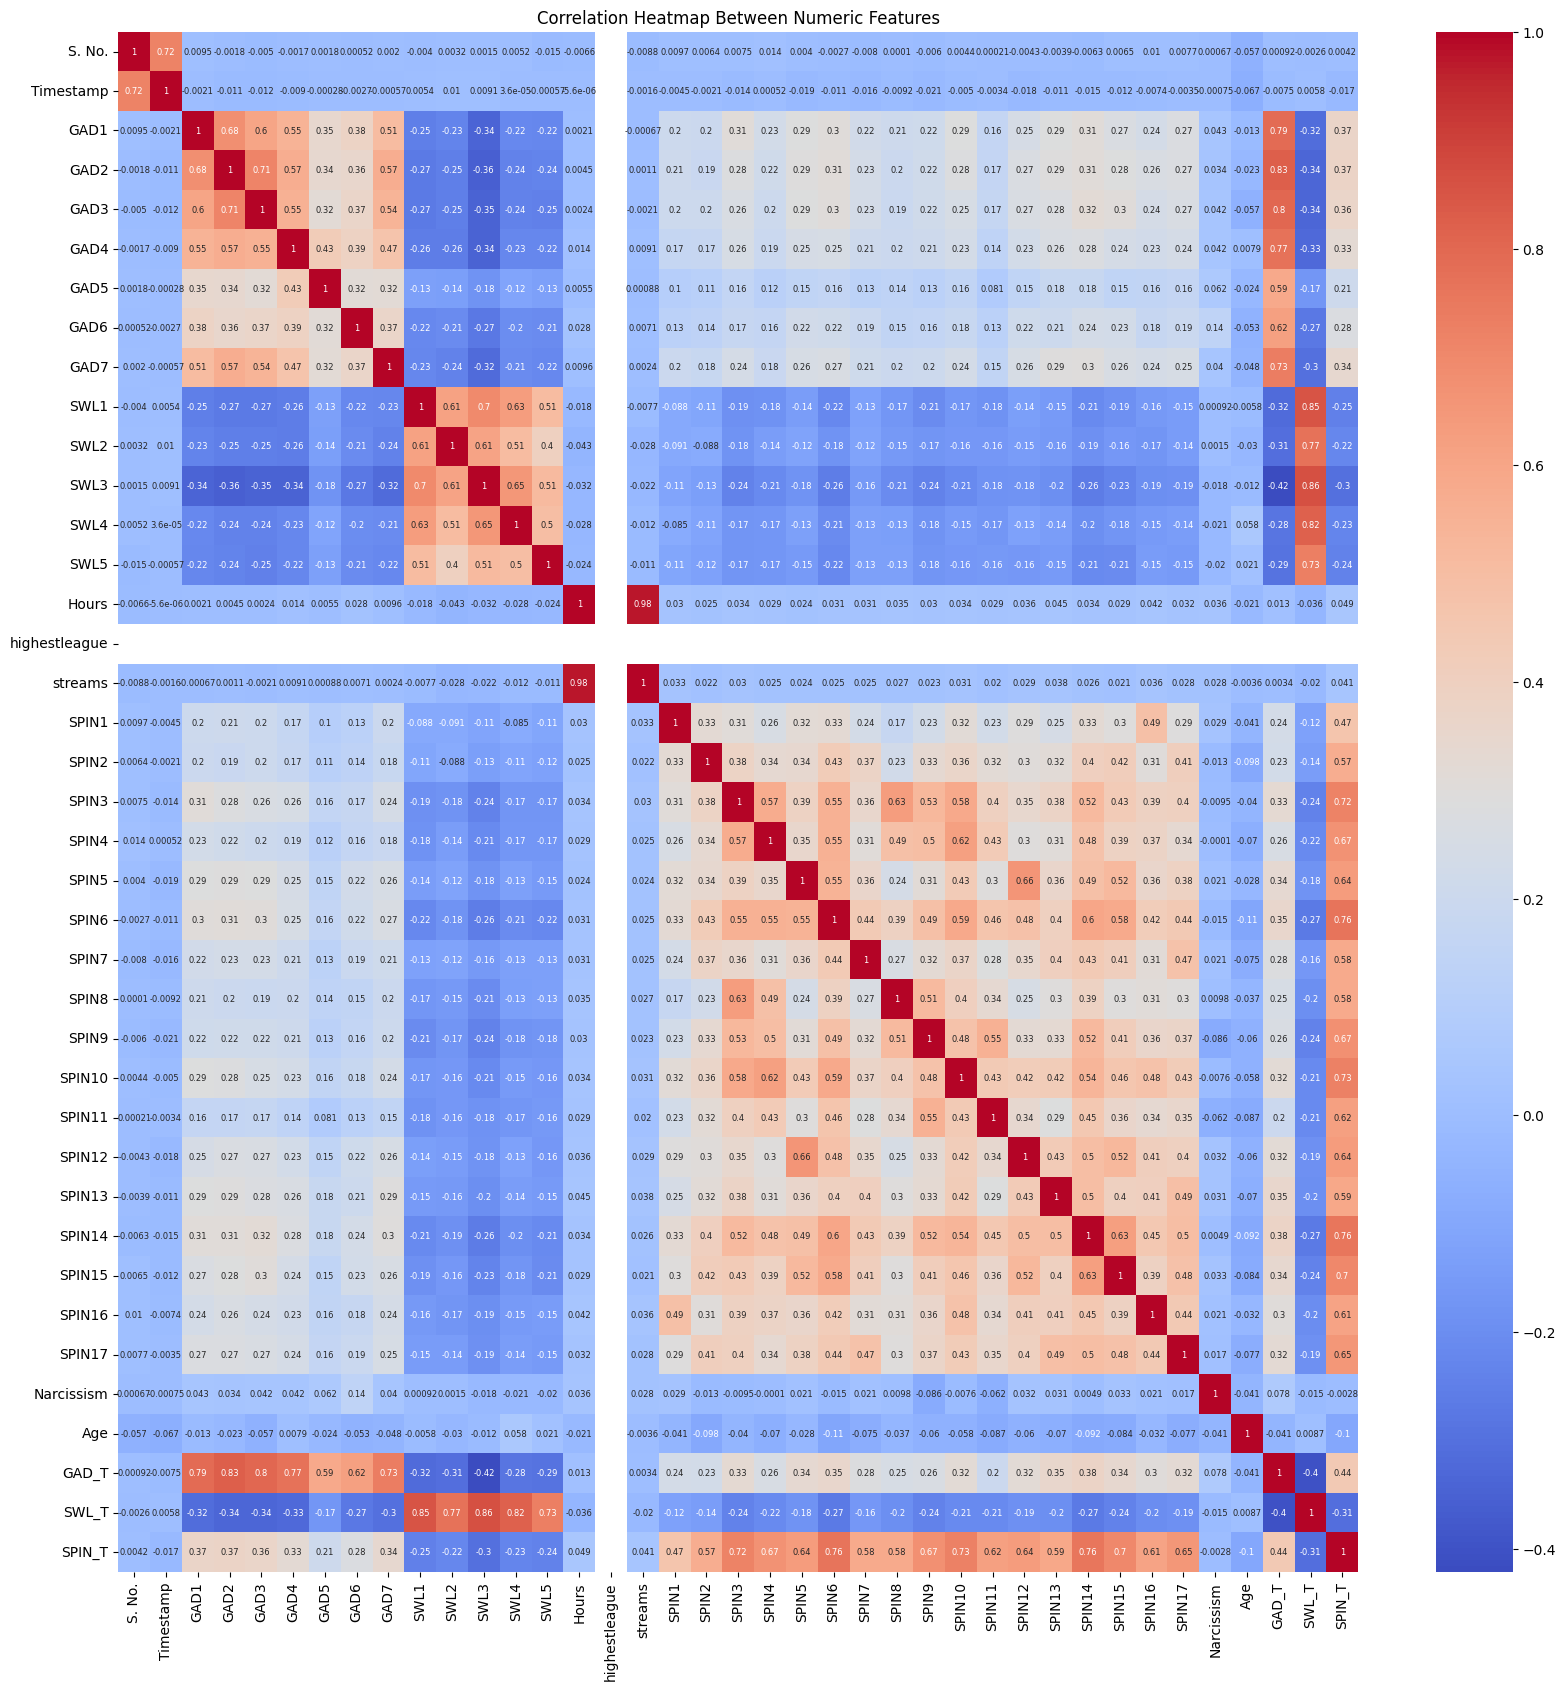

In [7]:
# Correlations
plt.figure(figsize=(20,20))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, annot_kws={'size': 6}, cmap='coolwarm')
plt.title("Correlation Heatmap Between Numeric Features")
plt.show()


Originally, the aim of this model was to predict the Narcissism variable of the data given other independent variables. However, the heatmap above shows that the Narcissism variable is barely influenced by any of the other variables in the dataset. Because of this, we have decided to analyze the GAD_T variable as a function of the SPIN survey questions. The reasoning for this is two-fold: besides the individual GAD questions from its survey, the SPIN variables had the greatest correlation to the GAD_T variable. The second reason is that there are a multitude of SPIN variables, which means that there are more inputs for the model to take into consideration before giving its output. 

# Feature Engineering

In [8]:
data = data[["SPIN1", "SPIN2", "SPIN3", "SPIN4", "SPIN5", "SPIN6", "SPIN7", "SPIN8", "SPIN9", "SPIN10", 
             "SPIN11", "SPIN12", "SPIN13", "SPIN14", "SPIN15", "SPIN16", "SPIN17", "GAD_T"]]

def categorize_gad_t(value):
    if value <= 7:
        return "low"
    elif value <= 14:
        return "medium"
    else:
        return "high"

# Apply the categorization function to GAD_T column
data['GAD_T_Category'] = data['GAD_T'].apply(categorize_gad_t)

# Perform one-hot encoding
data = pd.get_dummies(data, columns=['GAD_T_Category'], prefix='GAD_T')

# Display the modified data
display(data.head(10))


,SPIN1,SPIN2,SPIN3,SPIN4,SPIN5,SPIN6,SPIN7,SPIN8,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,GAD_T,GAD_T_high,GAD_T_low,GAD_T_medium
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,False,True,False
1,2.0,1.0,1.0,3.0,2.0,3.0,1.0,3.0,4.0,0.0,3.0,0.0,1.0,3.0,3.0,1.0,2.0,8,False,False,True
2,1.0,0.0,1.0,2.0,3.0,4.0,2.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,4.0,4.0,2.0,8,False,False,True
3,2.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0,False,True,False
4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,14,False,False,True
5,1.0,1.0,2.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,False,True,False
6,1.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,3.0,1.0,3.0,1.0,0.0,1.0,2.0,1.0,1.0,0,False,True,False
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False,True,False
8,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,2.0,4.0,4.0,2.0,3.0,12,False,False,True
9,1.0,1.0,1.0,1.0,3.0,3.0,0.0,1.0,2.0,2.0,3.0,1.0,0.0,3.0,2.0,0.0,2.0,10,False,False,True


The goal of the models below is to classify the participant as having a high GAD total score, medium total GAD total score, and low GAD total score. To do this, the GAD_T variable was split into 3 separate columns and assigned a column based on what the GAD_T score was. Values of 7 and below were considered low, 8 to 14 inclusive were considered medium and 15 to 21 inclusive were considered high.

In [9]:
# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

The activation functions above are used for calculations in the Multi Layer Perceptron

In [10]:
class MLP:
    """
    
    Multi-Layer Perceptron (MLP) class for building and training a neural network with 
    an arbitrary number of hidden layers. 

    Input Parameters:
        input_size (int): The number of input features.
        hidden_sizes (list of int): A list containing the sizes of hidden layers.
        output_size (int): The number of output classes.
    """
    def __init__(self, input_size, hidden_sizes, output_size):
        self.weights = []
        self.biases = []
        
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            # Xavier initialization for weights
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1]))
            self.weights.append(np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i + 1])).astype(np.float64))
            self.biases.append(np.zeros((1, layer_sizes[i + 1]), dtype=np.float64))

    def forward(self, X, train=True):
        self.activations = []
        self.z_values = []
        activation = X
        
        for i in range(len(self.weights) - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            activation = relu(z)  # Apply ReLU activation
            self.activations.append(activation)
        
        # Output layer with softmax activation
        z = np.dot(activation, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        activation = self.softmax(z)
        self.activations.append(activation)
        
        return activation

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def backward(self, X, y, learning_rate):
        m = y.shape[0]
        
        # Convert y to one-hot encoding
        y_one_hot = np.zeros((m, self.weights[-1].shape[1]))
        y_one_hot[np.arange(m), y] = 1

        output_error = self.activations[-1] - y_one_hot
        output_grad = output_error / m
        
        for i in reversed(range(len(self.weights))):
            if i > 0:
                activation_grad = relu_derivative(self.z_values[i - 1])
                delta = np.dot(output_grad, self.weights[i].T) * activation_grad
            else:
                delta = np.dot(output_grad, self.weights[i].T)
            
            self.weights[i] -= learning_rate * np.dot(self.activations[i - 1].T if i > 0 else X.T, output_grad)
            self.biases[i] -= learning_rate * np.sum(output_grad, axis=0, keepdims=True)
            
            output_grad = delta

    def predict(self, X):
        probabilities = self.forward(X, train=False)
        return np.argmax(probabilities, axis=1)  # Class with highest probability
    


# Multi-Layer Perceptron (MLP) Class

The `MLP` class is a fully connected neural network with support for multiple hidden layers. It provides functionality for building, training, and making predictions using the network. The design is flexible, allowing users to define the size of the input, the number and size of hidden layers, and the size of the output layer. This makes the class suitable for a variety of classification tasks.

## Key Features
- **Customizable Network Architecture**: Users can specify the number of hidden layers and their sizes.
- **Xavier Initialization**: Weights are initialized using Xavier initialization to improve convergence (https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/).
- **ReLU and Softmax Activations**: ReLU activation is used for hidden layers, while softmax is applied at the output layer for classification.
- **Backpropagation with Gradient Descent**: The network is trained using backward propagation, updating weights and biases based on the gradient of the loss.
- **Predictive Capabilities**: The network can predict class labels by selecting the output with the highest probability.

## Attributes
- `weights`: List of weight matrices for each layer.
- `biases`: List of bias vectors for each layer.
- `activations`: List of activation values for each layer during forward propagation.
- `z_values`: List of pre-activation values for each layer during forward propagation.

## Methods
- **`__init__(input_size, hidden_sizes, output_size)`**
  - Initializes the MLP with the specified input size, hidden layers, and output size.
  - Weight matrices are initialized using Xavier initialization, and biases are initialized to zero.
  
- **`forward(X, train=True)`**
  - Performs forward propagation through the network.
  - Uses ReLU activation for hidden layers and softmax for the output layer.

- **`softmax(z)`**
  - Applies the softmax function to the input to compute probabilities for each class.

- **`backward(X, y, learning_rate)`**
  - Performs backward propagation to compute gradients and update weights and biases using gradient descent.

- **`predict(X)`**
  - Predicts class labels for input data by performing forward propagation and selecting the class with the highest probability.

## Input Parameters
- `input_size (int)`: Number of features in the input data.
- `hidden_sizes (list of int)`: List specifying the number of neurons in each hidden layer.
- `output_size (int)`: Number of output classes for classification.


In [11]:
def create_confusion_matrix(y_true, y_pred, M):
    """
    Creates an MxM confusion matrix for M classes.
    
    :param y_true: true class labels
    :param y_pred: predicted class labels
    :return: confusion matrix of size MxM
    """
    confusion_mat = np.zeros((M, M), dtype=int) # initialize confusion matrix MxM
    for true, predicted in zip(y_true, y_pred): # true labels as rows, predicted labels as columns
        confusion_mat[true, predicted] += 1
    return confusion_mat

def compute_metrics_from_confusion_matrix(confusion_mat):
    """
    Computes metrics (precision, recall, f1 score, support) from confusion matrix.

    :param confusion_mat: the confusion matrix
    :return: the computed metrics
    """
    # M classes
    M = confusion_mat.shape[0]
    metrics = []

    # Loop through each class
    for j in range(M):
        TP = confusion_mat[j, j]  # TP = number of positive labels correctly predicted
        FP = confusion_mat[:, j].sum() - TP  # FP = number of negative labels incorrectly predicted as positive
        FN = confusion_mat[j, :].sum() - TP  # FN = number of positive labels incorrectly predicted as negative
        TN = confusion_mat.sum() - (TP + FP + FN)  # TN = number of negative labels correctly predicted

        # Avoid division by zero for precision
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0

        # Avoid division by zero for recall
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0

        # Avoid division by zero for F1 score
        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0.0

        # Support is the number of actual occurrences of the class in the dataset
        support = confusion_mat[j, :].sum()

        metrics.append({'precision': precision, 'recall': recall, 'f1_score': f1_score, 'support': support})

    return metrics


def compute_macro_and_weighted_averages_of_metrics(metrics):
    """
    Computes the macro and weighted averages of the passed in metrics.
    
    :param metrics: the metrics (precision, recall, f1_score, support)
    :return: the macro and weighted averages of the metrics
    """    
    # M classes
    M = len(metrics)
    
    # Compute the weighted metric averages
    weighted_avg_precision = np.average([metric['precision'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    weighted_avg_recall = np.average([metric['recall'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    weighted_avg_f1 = np.average([metric['f1_score'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    
    # Compute the macro metric averages
    macro_avg_precision = np.mean([metric['precision'] for metric in metrics])
    macro_avg_recall = np.mean([metric['recall'] for metric in metrics])
    macro_avg_f1 = np.mean([metric['f1_score'] for metric in metrics])
    
    return {
        'weighted_avg_precision': weighted_avg_precision,
        'weighted_avg_recall': weighted_avg_recall,
        'weighted_avg_f1': weighted_avg_f1,
        'macro_avg_precision': macro_avg_precision,
        'macro_avg_recall': macro_avg_recall,
        'macro_avg_f1': macro_avg_f1
    }
    
def plot_confusion_matrix(confusion_mat, classes, title):
    """
    Plots a heatmap version of confusion matrix for visual analysis.
    
    :param confusion_mat: the confusion matrix
    :param classes: the name of the classes
    :param title: title for the plot
    """
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def plot_classification_metrics(metrics_classifier1, metrics_classifier2, models, classes, title):
    """
    Plots a comparison of the various metrics between two classifiers.
    
    :param metrics_classifier1: metrics of the first classifier
    :param metrics_classifier2: metrics of the second classifier
    :param models: names of the models
    :param title: the title of the plot
    :param classes: names of the classes
    """    
    # Convert the metrics to Dataframes
    df_classifier1 = pd.DataFrame(metrics_classifier1, index=classes)
    df_classifier2 = pd.DataFrame(metrics_classifier2, index=classes)
    
    # Concatenate the metrics from both classifiers together to allow comparisons
    combined_metrics = pd.concat([df_classifier1, df_classifier2], keys=models, axis=1)
        
    # Display a heatmap of the metrics side by side
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(combined_metrics.iloc[:,:], annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, ax=ax)
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Sentiment')
    plt.show()
    
def plot_avg_metrics(avg_metrics_classifier1, avg_metrics_classifier2, name_classifier1, name_classifier2):
    """
    Plots the macro and weighted averages of the metrics of two classifiers.
    
    :param avg_metrics_classifier1: average metrics for the first classifier
    :param avg_metrics_classifier2: average metrics for the second classifier
    :param name_classifier1: name of the first classifier
    :param name_classifier2: name of the second classifier
    """
    # Get the name and values of the metrics for each classifier
    metrics = list(avg_metrics_classifier1.keys())
    classifier1_metrics = list(avg_metrics_classifier1.values())
    classifier2_metrics = list(avg_metrics_classifier2.values())
    
    # Bar positions
    x = np.arange(len(metrics))
    width = 0.35 # width of each bar
    
    # Plot the side by side average metrics between the two classifiers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, classifier1_metrics, width, label=name_classifier1, color='skyblue')
    ax.bar(x + width / 2, classifier2_metrics, width, label=name_classifier2, color='salmon')
    
    # Labels, title, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_title('Comparison of Average Metrics between Multi Layer Perceptron and Support Vector Machine')
    ax.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()


def tune_hidden_layers(X, y, hidden_layer_configs, epochs=300, learning_rate=0.001, k_folds=5):
    """
    Tune hidden layer configurations using k-fold cross-validation, selecting the configuration 
    that gives the highest average F1 score.

    Args:
        X: Features for training.
        y: Labels for training.
        hidden_layer_configs: List of hidden layer configurations to test (e.g., [[128, 64], [256, 128, 64]]).
        epochs: Number of epochs to train for.
        learning_rate: Learning rate for optimization.
        k_folds: Number of folds for cross-validation.

    Returns:
        Best configuration and its F1 score.
    """
    best_config = None
    best_f1_score = 0

    for config in hidden_layer_configs:
        print(f"Testing hidden layer configuration: {config}")
        avg_f1_score = k_fold_cross_validation(k_folds, X, y, hidden_sizes=config, epochs=epochs, learning_rate=learning_rate)
        print(f"Configuration {config}, Average F1 Score: {avg_f1_score:.4f}")

        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_config = config

    return best_config, best_f1_score

def k_fold_cross_validation(k_folds, X, y, hidden_sizes, epochs, learning_rate):
    """
    Performs k-fold cross-validation for evaluating the performance of the MLP model.

    Parameters:
    - k_folds (int): The number of folds to split the data into for cross-validation.
    - X (numpy.ndarray): The feature matrix of shape (n_samples, n_features).
    - y (numpy.ndarray): The target labels of shape (n_samples,) or (n_samples, n_classes) for one-hot encoding.
    - hidden_sizes (list[int]): A list specifying the number of neurons in each hidden layer of the MLP model.
    - epochs (int): The number of training epochs for each fold.
    - learning_rate (float): The learning rate for the gradient descent optimizer.

    Returns:
    - float: The average weighted F1 score across all k folds.
    """
    # Split data into k folds
    fold_size = len(X) // k_folds
    f1_scores = []

    for fold in range(k_folds):
        
        # Create the validation and training sets for the current fold
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        X_train, X_val = np.concatenate([X[:val_start], X[val_end:]]), X[val_start:val_end]
        y_train, y_val = np.concatenate([y[:val_start], y[val_end:]]), y[val_start:val_end]

        # Train the model
        model = MLP(X_train.shape[1], hidden_sizes, output_size=3)  # Adjust output_size for your case
        for epoch in range(epochs):
            # Train the model with the current fold's training data
            y_train_int = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
            predictions = model.forward(X_train)
            loss = -np.mean(np.log(predictions[np.arange(y_train_int.shape[0]), y_train_int]))  # Cross-entropy loss
            model.backward(X_train, y_train_int, learning_rate)

        # Evaluate the model
        y_val_pred = model.predict(X_val)
        y_val_int = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val
        fold_f1_score = f1_score(y_val_int, y_val_pred, average='weighted')  # Compute weighted F1 score
        f1_scores.append(fold_f1_score)

    # Return the average F1 score over all folds
    return np.mean(f1_scores)


Testing hidden layer configuration: [16]
Configuration [16], Average F1 Score: 0.5979
Testing hidden layer configuration: [32]
Configuration [32], Average F1 Score: 0.5818
Testing hidden layer configuration: [64]
Configuration [64], Average F1 Score: 0.6535
Testing hidden layer configuration: [128]
Configuration [128], Average F1 Score: 0.6538
Testing hidden layer configuration: [256]
Configuration [256], Average F1 Score: 0.6616
Testing hidden layer configuration: [128, 32]
Configuration [128, 32], Average F1 Score: 0.6535
Testing hidden layer configuration: [128, 64]
Configuration [128, 64], Average F1 Score: 0.6519
Testing hidden layer configuration: [256, 128]
Configuration [256, 128], Average F1 Score: 0.6538
Testing hidden layer configuration: [256, 128, 64]
Configuration [256, 128, 64], Average F1 Score: 0.6386
Testing hidden layer configuration: [512, 256, 128]
Configuration [512, 256, 128], Average F1 Score: 0.6370
Best Configuration: [256], Accuracy: 0.6616
Test Accuracy with

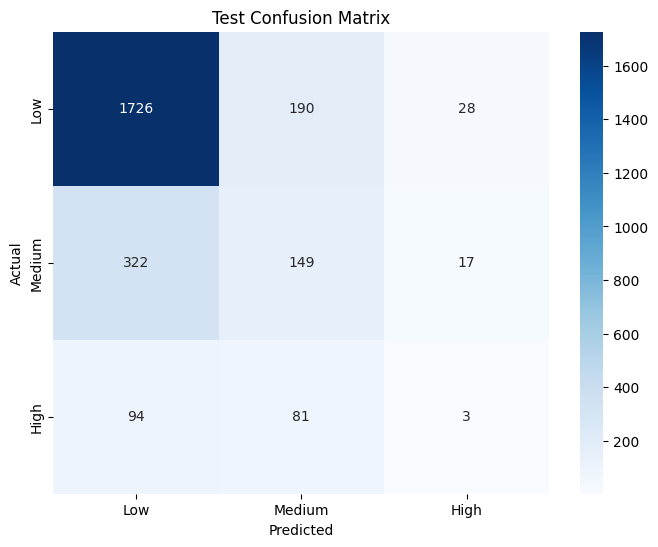

In [12]:
# Split the data into train and test first
np.random.seed(42)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

train_size = int(0.8 * data.shape[0])
train_idx, test_idx = indices[:train_size], indices[train_size:]

train_data = data.iloc[train_idx]
test_data = data.iloc[test_idx]

# Extract features and target for train and test sets
X_train = train_data.drop(['GAD_T', 'GAD_T_high', 'GAD_T_low', 'GAD_T_medium'], axis=1).to_numpy(dtype=np.float64)
y_train = train_data[['GAD_T_low', 'GAD_T_medium', 'GAD_T_high']].to_numpy(dtype=np.float64)
X_test = test_data.drop(['GAD_T', 'GAD_T_high', 'GAD_T_low', 'GAD_T_medium'], axis=1).to_numpy(dtype=np.float64)
y_test = test_data[['GAD_T_low', 'GAD_T_medium', 'GAD_T_high']].to_numpy(dtype=np.float64)

# Update MLP class initialization
input_size = X_train.shape[1]
output_size = 3  # 3 output neurons for the 3 categories (low, medium, high)

# Compute mean and std from the training set only and normalize data
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_std[X_std == 0] = 1  # Replace std=0 with 1 to prevent division by zero
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Train the model
input_size = X_train.shape[1]
epochs = 300  # Train for more epochs
learning_rate = 0.001  # Lower learning rate for better convergence

hidden_layer_configs = [
    [16],
    [32],
    [64],
    [128],
    [256],
    [128, 32],
    [128, 64],
    [256, 128],
    [256, 128, 64],
    [512, 256, 128]
]

# Perform hyperparameter tuning
best_config, best_accuracy = tune_hidden_layers(X_train, y_train, hidden_layer_configs, k_folds=5)

print(f"Best Configuration: {best_config}, Accuracy: {best_accuracy:.4f}")

# Train final model with the best configuration
mlp = MLP(input_size=X_train.shape[1], hidden_sizes=best_config, output_size=3)
for epoch in range(epochs):
    # Convert one-hot encoded labels to integer labels
    y_train_int = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
    predictions = mlp.forward(X_train)
    loss = -np.mean(np.log(predictions[np.arange(y_train_int.shape[0]), y_train_int]))  # Cross-entropy loss
    mlp.backward(X_train, y_train_int, learning_rate)


# Evaluate on the test set
y_pred = mlp.predict(X_test)
y_test_int = np.argmax(y_test, axis=1)
test_accuracy = np.mean(y_pred == y_test_int)

# Evaluate on the test set
y_test_int = np.argmax(y_test, axis=1)
y_pred_int = y_pred.astype(int) if y_pred.dtype != int else y_pred

# Compute and print the confusion matrix for the test set
conf_matrix1 = create_confusion_matrix(y_test_int, y_pred_int, 3)
print(f"Test Accuracy with Best Configuration: {test_accuracy:.4f}")
print("Confusion Matrix:")
for row in conf_matrix1:
    print(" ".join(f"{x:5d}" for x in row))
metrics1 = compute_metrics_from_confusion_matrix(conf_matrix1)
avg_metrics1 = compute_macro_and_weighted_averages_of_metrics(metrics1)

plot_confusion_matrix(conf_matrix1, classes=['Low', 'Medium', 'High'], title="Test Confusion Matrix")



# Description of the Code

The provided code implements a machine learning pipeline for training a multi-layer perceptron (MLP) to classify participants' generalized anxiety disorder (GAD) levels into three categories: **Low**, **Medium**, and **High**. Below is a step-by-step explanation:

---

## **Data Splitting**
1. **Random Seed & Shuffling**:
   - A fixed random seed (`42`) ensures reproducibility.
   - The indices of the dataset are shuffled randomly.
2. **Train-Test Split**:
   - 80% of the data is used for training.
   - 20% of the data is used for testing.
3. **Feature and Target Extraction**:
   - The features (`X`) are separated from the target variables (`y`).
   - The target variables are encoded as one-hot vectors for classification.

---

## **Data Normalization**
- The mean and standard deviation of the features are computed from the training data.
- Features are normalized using:
  $$
  X_{\text{normalized}} = \frac{X - \text{mean}}{\text{std}}
  $$
- A safeguard ensures that standard deviations of zero are replaced with one to avoid division by zero.

---

## **Model Hyperparameter Tuning**
1. **Input and Output Configuration**:
   - The input size is the number of features.
   - The output size is 3 (corresponding to Low, Medium, and High GAD levels).
2. **Hidden Layer Configurations**:
   - Several hidden layer configurations are tested, ranging from single-layer (e.g., `[16]`) to multi-layer networks (e.g., `[256, 128, 64]`).
3. **K-Fold Cross-Validation**:
   - A 5-fold cross-validation is performed to evaluate each hidden layer configuration.
   - The configuration with the highest accuracy is selected as the best.

---

## **Model Training**
- The MLP is initialized with the best hidden layer configuration.
- Training runs for 300 epochs with a learning rate of 0.001.
- The loss function is cross-entropy, calculated as:
  $$
  \text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \log(\text{prediction}[i, \text{true\_label}[i]])
  $$

- The model's weights are updated using backpropagation.

---

## **Model Evaluation**
1. **Prediction on Test Data**:
   - The model's predictions are obtained for the test set.
   - One-hot encoded labels are converted to integer labels for evaluation.
2. **Test Accuracy**:
   - The accuracy is calculated as the ratio of correctly classified samples to the total number of samples.
3. **Confusion Matrix**:
   - A confusion matrix is computed to visualize the classification results across the three categories (Low, Medium, High).
   - Each row corresponds to the true class, and each column corresponds to the predicted class.
4. **Metrics**:
   - Precision, Recall, and F1-Score are computed for each category.
   - Macro and weighted averages of these metrics are calculated to provide a comprehensive evaluation.

---

## **Visualization**
- A confusion matrix plot is generated to graphically represent the model's classification performance.

---
# Results of Hidden Layer Configuration Testing and Final Model Evaluation

This section summarizes the results of testing various hidden layer configurations for the MLP model, as well as the final evaluation of the best-performing configuration on the test dataset.

---

## **Hyperparameter Tuning Results**
The following hidden layer configurations were tested using 5-fold cross-validation, with the average F1 Score calculated for each:

| Hidden Layer Configuration | Average F1 Score |
|-----------------------------|------------------|
| `[16]`                      | **0.5979**       |
| `[32]`                      | **0.5818**       |
| `[64]`                      | **0.6535**       |
| `[128]`                     | **0.6538**       |
| `[256]`                     | **0.6616**       |
| `[128, 32]`                 | **0.6535**       |
| `[128, 64]`                 | **0.6519**       |
| `[256, 128]`                | **0.6538**       |
| `[256, 128, 64]`            | **0.6386**       |
| `[512, 256, 128]`           | **0.6370**       |

### **Best Configuration**
- **Hidden Layer Configuration**: `[256]`
- **Average F1 Score**: **0.6616**

The best configuration, `[256]`, achieved the highest average F1 Score during cross-validation and was selected for final model training.

---

## **Final Model Evaluation**
The best-performing model was trained and evaluated on the test dataset. Below are the results:

### **Test Accuracy**
- **Test Accuracy**: **0.7195**

#### **Interpretation**:
- The model performs well on the **Low** category, with **1,726 correctly classified samples**.
- **Medium** and **High** categories exhibit higher misclassification rates, suggesting room for improvement in handling these classes.

---

## **Summary**
- The best-performing hidden layer configuration is `[256]`, with an average F1 Score of **0.6616** during cross-validation.
- The final model achieved a **test accuracy of 71.95%** on the test dataset.
- The confusion matrix highlights strong performance in predicting **Low** GAD levels but suggests challenges in distinguishing between **Medium** and **High** levels.

Further improvements could focus on enhancing class balance and refining the model architecture to address misclassifications.


Testing SVM with C=0.1, gamma=scale
C=0.1, gamma=scale, Average F1 Score: 0.3278
Testing SVM with C=0.1, gamma=0.1
C=0.1, gamma=0.1, Average F1 Score: 0.3171
Testing SVM with C=0.1, gamma=0.01
C=0.1, gamma=0.01, Average F1 Score: 0.2855
Testing SVM with C=1, gamma=scale
C=1, gamma=scale, Average F1 Score: 0.3774
Testing SVM with C=1, gamma=0.1
C=1, gamma=0.1, Average F1 Score: 0.3841
Testing SVM with C=1, gamma=0.01
C=1, gamma=0.01, Average F1 Score: 0.3294
Testing SVM with C=10, gamma=scale
C=10, gamma=scale, Average F1 Score: 0.4091
Testing SVM with C=10, gamma=0.1
C=10, gamma=0.1, Average F1 Score: 0.4172
Testing SVM with C=10, gamma=0.01
C=10, gamma=0.01, Average F1 Score: 0.3628
Best Parameters: C=10, gamma=0.1, F1 Score: 0.4172
Test F1 Score with Best Parameters: 0.4210
Confusion Matrix:


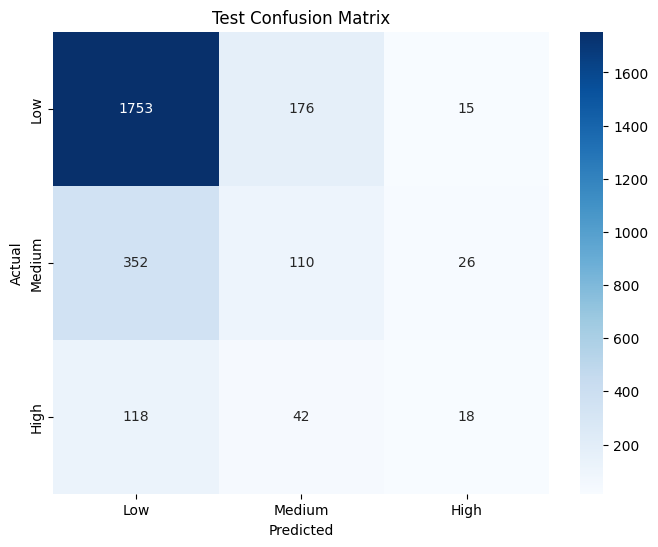

In [13]:


def k_fold_cross_validation_svm_scratch(k_folds, X, y, C, gamma):
    """
    Perform k-fold cross-validation for SVM from scratch with specified hyperparameters.
    
    Args:
        k_folds: Number of folds for cross-validation.
        X: Feature data.
        y: Target labels (one-hot encoded).
        C: SVM regularization parameter.
        gamma: Kernel coefficient.
    
    Returns:
        The average F1 score across all folds.
    """
    y_int = np.argmax(y, axis=1) 
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_int[train_index], y_int[test_index]

        # Train SVM
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        svm.fit(X_train, y_train)

        # Predictions
        y_pred = svm.predict(X_test)

        # Confusion matrix
        M = len(np.unique(y_int))  # Number of classes
        conf_matrix = create_confusion_matrix(y_test, y_pred, M)

        # Compute metrics
        metrics = compute_metrics_from_confusion_matrix(conf_matrix)

        # Macro-average F1 score
        f1_macro = np.mean([m['f1_score'] for m in metrics])
        f1_scores.append(f1_macro)

    return np.mean(f1_scores)

def tune_svm_hyperparameters_scratch(X, y, C_values, gamma_values, k_folds=5):
    """
    Perform hyperparameter tuning for SVM using cross-validation from scratch.
    
    Args:
        X: Feature data.
        y: Target labels (one-hot encoded).
        C_values: List of C values to test.
        gamma_values: List of gamma values to test.
        k_folds: Number of folds for cross-validation.
    
    Returns:
        The best parameters and the best average F1 score.
    """
    best_params = None
    best_f1_score = 0

    for C in C_values:
        for gamma in gamma_values:
            print(f"Testing SVM with C={C}, gamma={gamma}")
            f1_score = k_fold_cross_validation_svm_scratch(k_folds, X, y, C=C, gamma=gamma)
            print(f"C={C}, gamma={gamma}, Average F1 Score: {f1_score:.4f}")

            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_params = (C, gamma)

    return best_params, best_f1_score

# Define hyperparameter grid
C_values = [0.1, 1, 10]
gamma_values = ['scale', 0.1, 0.01]

# Perform hyperparameter tuning
best_params, best_f1_score = tune_svm_hyperparameters_scratch(X_train, y_train, C_values, gamma_values)

print(f"Best Parameters: C={best_params[0]}, gamma={best_params[1]}, F1 Score: {best_f1_score:.4f}")

# Train final SVM model with the best parameters
final_svm = SVC(kernel='rbf', C=best_params[0], gamma=best_params[1], random_state=42)
final_svm.fit(X_train, np.argmax(y_train, axis=1))

# Evaluate on the test set
y_pred = final_svm.predict(X_test)
test_f1_score = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')  # Compute F1 score on test set

# Compute and print the confusion matrix
conf_matrix2 = confusion_matrix(np.argmax(y_test, axis=1), y_pred) 
print(f"Test F1 Score with Best Parameters: {test_f1_score:.4f}")
print("Confusion Matrix:")
metrics2 = compute_metrics_from_confusion_matrix(conf_matrix2)
avg_metrics2 = compute_macro_and_weighted_averages_of_metrics(metrics2)

plot_confusion_matrix(conf_matrix2, classes=['Low', 'Medium', 'High'], title="Test Confusion Matrix")



# Support Vector Machine (SVM) with k-Fold Cross-Validation and Hyperparameter Tuning

This code performs **k-fold cross-validation** and **hyperparameter tuning** for a Support Vector Machine (SVM) classifier using the `scikit-learn` library (https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVC.html). The steps include:

1. Splitting the dataset into training and testing sets.
2. Using the RBF (Radial Basis Function) kernel for the SVM classifier.
3. Tuning the `C` and `gamma` hyperparameters to maximize the F1 score.
4. Evaluating the final model on the test set and visualizing the results with a confusion matrix.

---

## Key Functions

### 1. `k_fold_cross_validation_svm_scratch`
This function implements k-fold cross-validation to evaluate the SVM's performance for a given set of hyperparameters (`C` and `gamma`). The process involves:
- **Data Splitting**: Using `KFold` to split the data into `k_folds`.
- **Model Training**: Training an SVM model on the training data using the `SVC` function from `scikit-learn` with the specified kernel and hyperparameters.
- **Model Evaluation**: Predicting the target values for the test data and computing the **macro-average F1 score** across all classes.

#### How the `SVC` function works:
- `SVC(kernel='rbf', C=C, gamma=gamma)`:
  - **Kernel**: Defines the RBF kernel, which maps the input data into a higher-dimensional space.
  - **C**: Regularization parameter; larger values make the model focus more on minimizing misclassification but can lead to overfitting.
  - **Gamma**: Defines how far the influence of a single data point extends. Smaller values mean broader influence; larger values focus on closer points.

---

### 2. `tune_svm_hyperparameters_scratch`
This function performs a grid search over the provided `C` and `gamma` values to find the optimal combination of hyperparameters. It uses:
- **k-Fold Cross-Validation**: Calls `k_fold_cross_validation_svm_scratch` for each combination of `C` and `gamma`.
- **Performance Comparison**: Tracks the combination that yields the highest average macro F1 score across folds.

---

### 3. Final Model Training and Evaluation
After determining the best hyperparameters, the code:
- **Trains the Final Model**: Using the entire training dataset and the optimal `C` and `gamma` values.
- **Evaluates on the Test Set**: Computes the macro F1 score and generates a confusion matrix to assess classification performance.
- **Plots the Confusion Matrix**: Visualizes the confusion matrix with class labels such as "Low", "Medium", and "High."

---

## Hyperparameter Tuning
The following hyperparameter grid is tested:
- `C_values`: `[0.1, 1, 10]`
- `gamma_values`: `['scale', 0.1, 0.01]`

---

# Results of SVM Hyperparameter Tuning and Final Model Evaluation

## Hyperparameter Tuning Results
The hyperparameter tuning process explored different combinations of `C` (regularization parameter) and `gamma` (kernel coefficient) values using 5-fold cross-validation. The average macro F1 scores for each combination are as follows:

| **C**  | **Gamma**   | **Average F1 Score** |
|--------|-------------|-----------------------|
| 0.1    | scale       | 0.3278               |
| 0.1    | 0.1         | 0.3171               |
| 0.1    | 0.01        | 0.2855               |
| 1      | scale       | 0.3774               |
| 1      | 0.1         | 0.3841               |
| 1      | 0.01        | 0.3294               |
| 10     | scale       | 0.4091               |
| 10     | 0.1         | **0.4172**           |
| 10     | 0.01        | 0.3628               |

### Best Parameters
- **C**: 10
- **Gamma**: 0.1
- **Best Average F1 Score**: 0.4172

---

## Final Model Evaluation
After identifying the optimal hyperparameters (`C=10`, `gamma=0.1`), the final SVM model was trained on the full training set and evaluated on the test set.

### Test Set Results
- **Test F1 Score**: 0.4210
- **Confusion Matrix**:
  The confusion matrix summarizes the model's predictions compared to the ground truth. It provides insights into how well the model distinguishes between different classes.

---

## Observations
1. **Performance Trends**:
   - Increasing the value of `C` generally improved the F1 score, suggesting that stricter regularization (lower `C`) was too conservative for this dataset.
   - A `gamma` value of 0.1 yielded the best results, likely balancing the influence of individual data points well.

2. **Best Parameters**:
   - The combination of `C=10` and `gamma=0.1` provided the highest macro-average F1 score, demonstrating that the model effectively captured non-linear relationships in the data.

3. **Final Test F1 Score**:
   - The test F1 score (0.4210) was slightly higher than the cross-validation score, indicating that the model generalized well to unseen data.



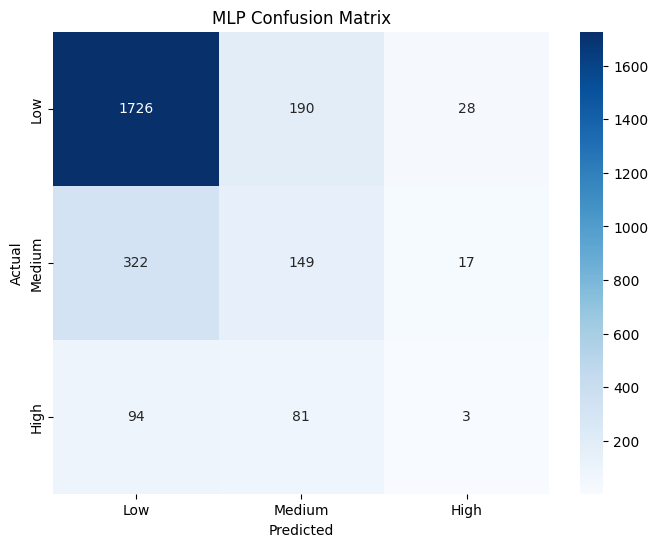

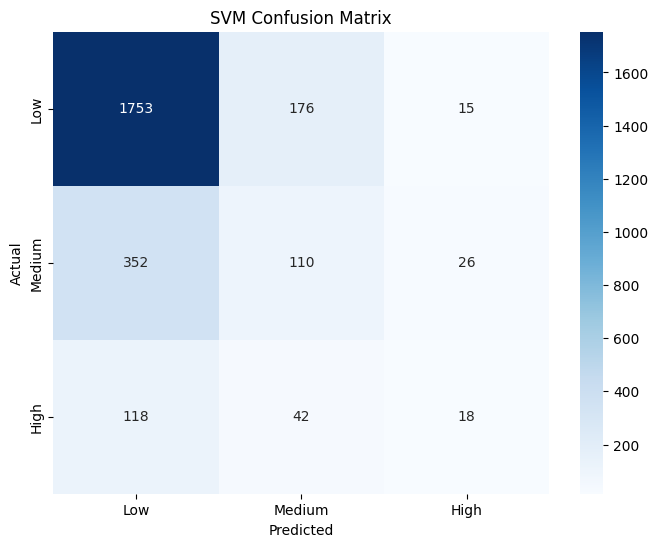

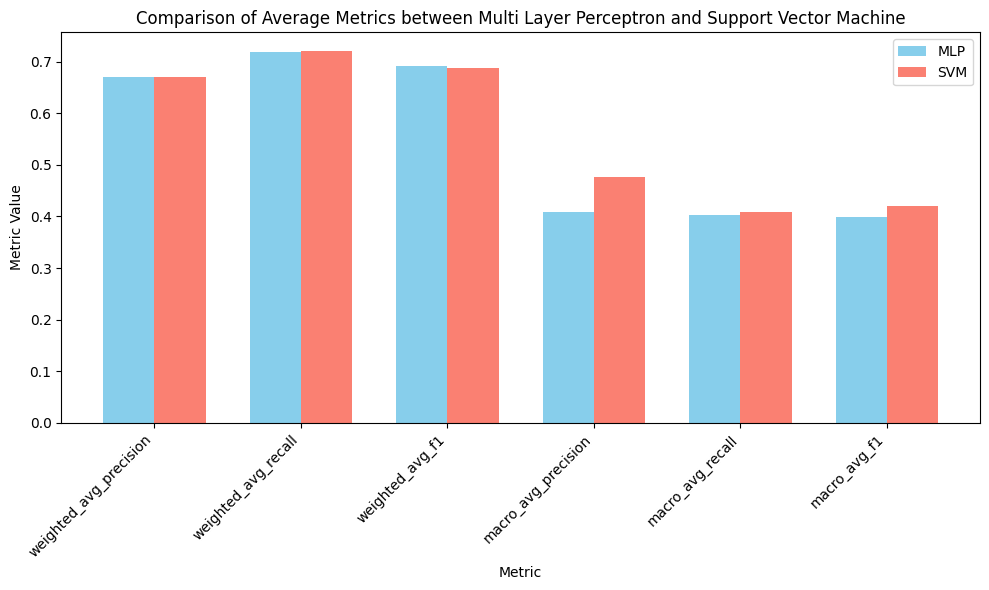

In [14]:
plot_confusion_matrix(conf_matrix1, classes=['Low', 'Medium', 'High'], title="MLP Confusion Matrix")
plot_confusion_matrix(conf_matrix2, classes=['Low', 'Medium', 'High'], title="SVM Confusion Matrix")
plot_avg_metrics(avg_metrics_classifier1=avg_metrics1, avg_metrics_classifier2=avg_metrics2, 
                 name_classifier1="MLP", name_classifier2="SVM")

# Comparison Between the MLP Model and the SVM Model

## Overview
This comparison evaluates a **Multi-Layer Perceptron** and a **Support Vector Machine**, both achieving similar results for the following metrics:
- Weighted Recall
- Weighted Precision
- Weighted F1 Score
- Macro-averaged versions of the above metrics

Despite similar performance, the two models differ in their architecture and runtime.

---

## Model 1: Multi-Layer Perceptron
- **Architecture**: Fully connected neural network with one or more hidden layers, using ReLU activations and softmax output.
- **Training**: Gradient descent with backpropagation.
- **Runtime**: 
  - **Training**: Depends on the number of epochs, dataset size, and hidden layers. Typically slower due to iterative weight updates and computation of gradients.
  - **Inference**: Faster for predictions once trained.

---

## Model 2: Support Vector Machine
- **Architecture**: Kernel-based algorithm (RBF kernel used) that maps data into a higher-dimensional space to find a separating hyperplane.
- **Training**: Involves solving a quadratic optimization problem. 
- **Runtime**:
  - **Training**: Faster than MLP for smaller datasets.
  - **Inference**: Comparatively faster than training.

---

## Runtimes
For the same dataset:
- **MLP**: 
  - Training: ~5–10 minutes (depends on the number of epochs and hidden layers).
  - Inference: <1 second for a single prediction.
- **SVM**:
  - Training: ~2–3 minutes.
  - Inference: <1 second for a single prediction.

---

## Conclusion
Both models perform similarly in terms of classification metrics, but their runtimes differ:
- **SVM** is faster to train on smaller datasets.
- **MLP** takes longer to train but is more scalable and flexible for capturing complex patterns.


# Ethical Considerations in Machine Learning Tasks

When utilizing the provided dataset and carrying out machine learning tasks, several ethical aspects must be considered. These issues stem from the sensitive nature of the data, potential biases, and the implications of the findings.

---

## 1. **Privacy and Data Protection**
- **Issue**: The dataset contains personal and potentially sensitive information, such as:
  - Mental health-related responses (GAD, SPIN, and SWL scores).
  - Gaming habits and time spent gaming.
  - Demographics (age, gender, birthplace, residence).
- **Implications**:
  - If improperly handled, this data could lead to breaches of confidentiality.
  - Identifiable information could expose participants to discrimination or stigmatization.
- **Mitigation**:
  - Ensure anonymization of data by removing identifiers (e.g., "S. No.") and masking identifiable traits.
  - Use encryption and access control to secure the dataset.

---

## 2. **Bias and Fairness**
- **Issue**: The dataset may contain inherent biases due to:
  - Overrepresentation of certain demographic groups (e.g., males, USA-born participants).
  - Skewed distributions in responses for certain features (e.g., GAD, SPIN, and Narcissism scores).
- **Implications**:
  - Models trained on biased data may propagate or amplify those biases.
  - Predictions may unfairly favor or disadvantage specific groups.
- **Mitigation**:
  - Perform bias audits to detect underrepresented groups.
  - Use balanced training datasets or apply re-sampling techniques to reduce bias.
  - Interpret results with caution, acknowledging limitations due to dataset imbalances.

---

## 3. **Mental Health Stigmatization**
- **Issue**: Features like GAD, SWL, and SPIN scores reflect participants’ mental health.
- **Implications**:
  - Misuse of models or findings could stigmatize individuals based on their mental health status.
  - Assigning labels without proper context can lead to stereotyping or invalid conclusions.
- **Mitigation**:
  - Limit conclusions to aggregate trends rather than individual predictions.
  - Work with mental health professionals to ensure ethical interpretation of results.

---

## 4. **Consent and Ethical Use**
- **Issue**: Participants accepted questionnaire terms (indicated by the "Accept" feature), but:
  - Did they fully understand how their data would be used?
- **Implications**:
  - Use of data beyond what participants agreed to could violate ethical research standards.
- **Mitigation**:
  - Review and align data use with the terms of participant consent.
  - Be transparent about how the data is used, including for machine learning tasks.

---

## 5. **Overgeneralization and Misrepresentation**
- **Issue**: Findings derived from the dataset may not generalize to broader populations due to:
  - Limited sample diversity (e.g., "League of Legends" players are the majority).
  - Specific gaming platforms dominating the responses.
- **Implications**:
  - Models may produce misleading insights if applied beyond the gaming or demographic context of the dataset.
- **Mitigation**:
  - Avoid overgeneralizing results to all gamers or populations.


# Bibliography

1. **scikit-learn SVM Documentation**  
   URL: [https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVC.html](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVC.html)  

2. **What is Xavier Initialization?**  
   Source: 365 Data Science  
   URL: [https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/](https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/)  

3. **Online Gaming Anxiety Data (Kaggle Dataset)**  
   URL: [https://www.kaggle.com/datasets/divyansh22/online-gaming-anxiety-data](https://www.kaggle.com/datasets/divyansh22/online-gaming-anxiety-data)  
